In [1]:
shape_cat=""
vol=""
z_range=""
key=""
quantile=""
test=""
z_diff=""

In [2]:
# Parameters
shape_cat = "mcal"
vol = "uber"
z_range = "all_z"
key = ""
quantile = ""
test = "background"
z_diff = 0.05


In [3]:
#This header file contains all the common packages
%matplotlib inline
%run /home/cz136/project/sa/lib/src/header.py $shape_cat $vol $z_range 
%run -i /home/cz136/project/sa/lib/src/func.py  

In [4]:
z_diff=float(z_diff)

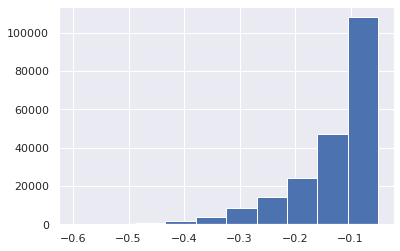

In [5]:
if test=="foreground":
    members=shapes[(shapes[('All','Z')]-shapes[('All','ZRED2')])>=z_diff]
    diff=members[('All','Z')]-members[('All','ZRED2')]
    diff.hist()
    diff.describe()
    
elif test=="background":
    members=background=shapes[(shapes[('All','Z')]-shapes[('All','ZRED2')])<=-z_diff]
    diff=members[('All','Z')]-members[('All','ZRED2')]
    diff.hist()
    diff.describe()
elif test=="":
    members=shapes
else:
    raise TypeError

In [6]:
if vol!="uber":
    members=shapes

In [7]:
if quantile!="":
    i=int(quantile)

In [8]:
if key=="lambda":
    key=('All','All','LAMBDA_CHISQ')
elif key=="z":
    key=('All','All','Z_LAMBDA')

In [9]:
def thirds_by_key(catalog,key):
    step0=catalog[key].quantile(0.0)
    step1=catalog[key].quantile(0.333333)
    step2=catalog[key].quantile(0.666666)
    step3=catalog[key].quantile(1)
    
    catalog1=catalog[(catalog[key]>step0) & (catalog[key]<step1)]
    catalog2=catalog[(catalog[key]>step1) & (catalog[key]<step2)]
    catalog3=catalog[(catalog[key]>step2) & (catalog[key]<step3)]
    
    return (catalog1,catalog2,catalog3)

In [10]:
if key!="":
    clusters_list=thirds_by_key(clusters,key)
    clusters=clusters_list[i]

In [11]:
sep="------------------------------------------------------------------------------"
np.set_printoptions(precision=4)

In [12]:
NBINS=10

In [13]:
import treecorr
import astropy.cosmology
from fastprogress import master_bar, progress_bar
from ipywidgets import FloatProgress
from IPython.display import display
from tqdm import tqdm

In [14]:
len(shapes)

1079244

In [15]:
len(members)

208083

In [16]:
if key=="":
    assert np.isin(shapes['All','MEM_MATCH_ID'].to_numpy(),clusters.index.to_numpy()).all()==True

In [17]:
def get_ng(cluster,mode1,mode2):
    if mode2=="abs":
        UPPER_BOUND=np.max(shapes[('All','R')])
        distance=('All','angR')
        
    elif mode2=="rel":
        UPPER_BOUND=1.2
        distance=('All','normLR')
    else:
        raise

    if mode1 == "s":
        def get_cluster_cen(cluster):
            return (get_unique_center_for_cluster(cluster))
        def get_cluster_sats(cluster):
            cen_mat_id=cluster.name
            cen_id=cluster[('Alt','Alt1','ID_CENT')]
            sats=members[members['All','MEM_MATCH_ID']==cen_mat_id]
            sats=sats[sats.index!=cen_id]
            return (sats)
    elif mode1=='r':
        def get_cluster_sats(cluster):
            return(shapes)
        def get_cluster_cen(cluster):
            return (random)

    else:
        raise


    cen=get_cluster_cen(cluster)
    sats=get_cluster_sats(cluster)


    sats_e1=sats[('All','e1')].to_numpy()
    sats_e2=sats[('All','e2')].to_numpy()
    sats_angr=sats[distance]

#     print(sats_e1,sats_e2)

    if type(cen[('All','RA')])==np.float64:
        cen_angr=np.array(cen[distance]).reshape(1)
        cen_ra=np.array(cen[('All','RA')]).reshape(1)
        cen_dec=np.array(cen[('All','DEC')]).reshape(1)
    else:
#         cen_e1=cen[('All','e1')].to_numpy
#         cen_e2=cen[('All','e2')].to_numpy()
        cen_angr=cen[distance].to_numpy()
        cen_ra=cen[('All','RA')].to_numpy()
        cen_dec=cen[('All','DEC')].to_numpy()




#     print(cen_e1,cen_e2)

    sats_ra=sats[('All','RA')].to_numpy()
    sats_dec=sats[('All','DEC')].to_numpy()




#     print(np.shape(cen_ra),np.shape(cen_dec))    
#     print(cen_ra,cen_dec)    

    sats_cat = treecorr.Catalog( g1 = sats_e1, g2   = sats_e2, 
                                 ra = sats_ra, dec = sats_dec,r=sats_angr,
                                 ra_units='deg', dec_units='deg')

    cen_cat = treecorr.Catalog( 
                                 ra = cen_ra, dec = cen_dec, r=cen_angr,
                                 ra_units='deg', dec_units='deg')

    ng = treecorr.NGCorrelation(nbins=NBINS, min_sep=0.01, max_sep=UPPER_BOUND, bin_slop=0.0,
                               metric="Rperp")
    ng.process_cross(cen_cat,sats_cat)

    return(ng)

In [18]:
def get_xi_meanlogr_varxi_npairs(cluster,mode1,mode2):
    ng=get_ng(cluster,mode1,mode2)
    return(np.array([ng.xi,ng.meanlogr,ng.varxi,ng.npairs]))

In [19]:
length=len(clusters)

def get_ng_list(mode2):
    ng_list=np.empty([length,4,NBINS])
    filler=np.zeros([1,4,NBINS])

    i=0
    e_count=0
    for index,cluster in tqdm(clusters.iterrows()):
        try:
            ng_list[i,:,:]=get_xi_meanlogr_varxi_npairs(cluster,'s',mode2)
            i=i+1
        except ValueError as e:
            ng_list[i,:,:]=filler
            i=i+1
            e_count=e_count+1
    print("Number of empty sat catalogs is {}".format(e_count))
    return (ng_list)

In [20]:
ng_abs=get_ng_list('abs')
ng_rel=get_ng_list('rel')

0it [00:00, ?it/s]

1it [00:00,  7.78it/s]

6it [00:00, 10.37it/s]

12it [00:00, 13.69it/s]

16it [00:00, 16.61it/s]

21it [00:00, 20.33it/s]

25it [00:00, 23.78it/s]

30it [00:00, 28.05it/s]

34it [00:00, 29.83it/s]

40it [00:01, 34.89it/s]

45it [00:01, 33.35it/s]

50it [00:01, 36.01it/s]

55it [00:01, 36.98it/s]

60it [00:01, 37.83it/s]

65it [00:01, 37.01it/s]

70it [00:01, 37.64it/s]

74it [00:01, 34.92it/s]

79it [00:02, 37.40it/s]

83it [00:02, 34.35it/s]

88it [00:02, 36.60it/s]

93it [00:02, 38.82it/s]

99it [00:02, 42.49it/s]

105it [00:02, 45.22it/s]

111it [00:02, 47.86it/s]

117it [00:02, 49.00it/s]

123it [00:03, 45.56it/s]

128it [00:03, 41.35it/s]

133it [00:03, 43.11it/s]

138it [00:03, 42.37it/s]

143it [00:03, 43.83it/s]

148it [00:03, 40.80it/s]

153it [00:03, 42.18it/s]

159it [00:03, 44.74it/s]

165it [00:03, 46.64it/s]

170it [00:04, 43.45it/s]

175it [00:04, 44.30it/s]

180it [00:04, 40.70it/s]

185it [00:04, 41.96it/s]

190it [00:04, 39.77it/s]

195it [00:04, 41.22it/s]

200it [00:04, 40.79it/s]

205it [00:04, 41.17it/s]

211it [00:05, 45.11it/s]

218it [00:05, 48.48it/s]

225it [00:05, 52.90it/s]

231it [00:05, 50.70it/s]

239it [00:05, 55.59it/s]

245it [00:05, 50.27it/s]

251it [00:05, 52.70it/s]

258it [00:05, 53.58it/s]

264it [00:06, 53.70it/s]

270it [00:06, 49.47it/s]

276it [00:06, 52.08it/s]

282it [00:06, 48.46it/s]

287it [00:06, 46.22it/s]

294it [00:06, 51.22it/s]

301it [00:06, 54.76it/s]

307it [00:06, 52.56it/s]

313it [00:07, 48.57it/s]

319it [00:07, 46.29it/s]

325it [00:07, 48.22it/s]

330it [00:07, 43.68it/s]

335it [00:07, 42.41it/s]

340it [00:07, 39.90it/s]

345it [00:07, 40.41it/s]

350it [00:07, 40.22it/s]

355it [00:08, 41.79it/s]

361it [00:08, 44.88it/s]

366it [00:08, 45.38it/s]

372it [00:08, 48.55it/s]

378it [00:08, 51.08it/s]

385it [00:08, 53.96it/s]

391it [00:08, 54.46it/s]

398it [00:08, 56.95it/s]

404it [00:08, 57.37it/s]

411it [00:09, 58.64it/s]

417it [00:09, 56.36it/s]

423it [00:09, 55.48it/s]

430it [00:09, 55.64it/s]

436it [00:09, 53.12it/s]

443it [00:09, 55.85it/s]

449it [00:09, 57.02it/s]

455it [00:09, 57.33it/s]

461it [00:09, 51.81it/s]

467it [00:10, 52.99it/s]

474it [00:10, 54.42it/s]

480it [00:10, 53.77it/s]

486it [00:10, 55.25it/s]

492it [00:10, 51.15it/s]

498it [00:10, 46.23it/s]

503it [00:10, 45.51it/s]

508it [00:10, 43.96it/s]

513it [00:11, 43.37it/s]

518it [00:11, 43.34it/s]

523it [00:11, 43.93it/s]

528it [00:11, 45.28it/s]

534it [00:11, 47.92it/s]

540it [00:11, 50.58it/s]

548it [00:11, 56.04it/s]

554it [00:11, 54.49it/s]

561it [00:11, 57.32it/s]

567it [00:12, 57.31it/s]

573it [00:12, 55.45it/s]

579it [00:12, 53.89it/s]

585it [00:12, 51.17it/s]

591it [00:12, 48.53it/s]

597it [00:12, 50.50it/s]

603it [00:12, 51.61it/s]

609it [00:12, 53.09it/s]

617it [00:12, 56.75it/s]

623it [00:13, 55.00it/s]

631it [00:13, 60.09it/s]

638it [00:13, 60.33it/s]

645it [00:13, 54.56it/s]

651it [00:13, 46.88it/s]

657it [00:13, 45.83it/s]

662it [00:13, 42.78it/s]

667it [00:13, 44.50it/s]

672it [00:14, 45.63it/s]

678it [00:14, 47.82it/s]

685it [00:14, 51.96it/s]

692it [00:14, 54.62it/s]

698it [00:14, 56.00it/s]

704it [00:14, 55.17it/s]

710it [00:14, 54.56it/s]

716it [00:14, 56.01it/s]

724it [00:14, 58.55it/s]

730it [00:15, 56.52it/s]

736it [00:15, 56.50it/s]

742it [00:15, 52.68it/s]

748it [00:15, 51.15it/s]

754it [00:15, 49.80it/s]

760it [00:15, 51.76it/s]

766it [00:15, 52.29it/s]

772it [00:15, 53.24it/s]

779it [00:16, 54.66it/s]

785it [00:16, 51.98it/s]

791it [00:16, 51.45it/s]

797it [00:16, 47.73it/s]

802it [00:16, 47.56it/s]

807it [00:16, 44.38it/s]

812it [00:16, 43.88it/s]

817it [00:16, 42.66it/s]

822it [00:17, 42.38it/s]

827it [00:17, 39.53it/s]

832it [00:17, 40.19it/s]

837it [00:17, 40.40it/s]

842it [00:17, 40.77it/s]

847it [00:17, 42.26it/s]

854it [00:17, 47.04it/s]

862it [00:17, 53.19it/s]

869it [00:17, 56.60it/s]

877it [00:18, 61.49it/s]

884it [00:18, 61.12it/s]

891it [00:18, 62.79it/s]

898it [00:18, 58.05it/s]

905it [00:18, 55.44it/s]

911it [00:18, 55.50it/s]

917it [00:18, 54.36it/s]

923it [00:18, 50.02it/s]

929it [00:19, 51.55it/s]

935it [00:19, 53.47it/s]

941it [00:19, 55.20it/s]

947it [00:19, 48.66it/s]

953it [00:19, 44.77it/s]

958it [00:19, 41.34it/s]

963it [00:19, 42.54it/s]

968it [00:19, 44.37it/s]

973it [00:20, 44.42it/s]

978it [00:20, 43.46it/s]

983it [00:20, 41.92it/s]

989it [00:20, 45.51it/s]

996it [00:20, 49.98it/s]

1002it [00:20, 51.83it/s]

1010it [00:20, 56.06it/s]

1017it [00:20, 58.29it/s]

1024it [00:20, 61.01it/s]

1031it [00:21, 56.47it/s]

1037it [00:21, 52.49it/s]

1043it [00:21, 52.88it/s]

1049it [00:21, 50.88it/s]

1055it [00:21, 52.28it/s]

1062it [00:21, 55.28it/s]

1068it [00:21, 52.54it/s]

1074it [00:21, 52.43it/s]

1080it [00:22, 49.14it/s]

1086it [00:22, 49.47it/s]

1092it [00:22, 48.37it/s]

1098it [00:22, 49.55it/s]

1103it [00:22, 46.38it/s]

1108it [00:22, 44.65it/s]

1113it [00:22, 44.00it/s]

1118it [00:22, 45.27it/s]

1123it [00:23, 41.59it/s]

1128it [00:23, 41.42it/s]

1133it [00:23, 42.18it/s]

1138it [00:23, 39.41it/s]

1144it [00:23, 42.32it/s]

1149it [00:23, 42.86it/s]

1156it [00:23, 47.12it/s]

1161it [00:23, 47.15it/s]

1166it [00:23, 47.30it/s]

1171it [00:24, 47.68it/s]

1176it [00:24, 46.88it/s]

1182it [00:24, 49.31it/s]

1187it [00:24, 47.96it/s]

1193it [00:24, 51.03it/s]

1199it [00:24, 51.18it/s]

1205it [00:24, 50.39it/s]

1211it [00:24, 49.85it/s]

1217it [00:24, 49.82it/s]

1223it [00:25, 50.22it/s]

1229it [00:25, 51.22it/s]

1235it [00:25, 49.66it/s]

1240it [00:25, 43.77it/s]

1245it [00:25, 43.09it/s]

1250it [00:25, 41.39it/s]

1255it [00:25, 41.64it/s]

1262it [00:25, 46.70it/s]

1270it [00:26, 51.71it/s]

1278it [00:26, 57.47it/s]

1286it [00:26, 60.94it/s]

1293it [00:26, 60.06it/s]

1300it [00:26, 59.85it/s]

1307it [00:26, 57.21it/s]

1313it [00:26, 55.31it/s]

1319it [00:26, 56.04it/s]

1325it [00:26, 56.83it/s]

1333it [00:27, 60.16it/s]

1340it [00:27, 57.56it/s]

1348it [00:27, 61.63it/s]

1355it [00:27, 61.32it/s]

1362it [00:27, 58.16it/s]

1368it [00:27, 54.98it/s]

1374it [00:27, 55.50it/s]

1380it [00:27, 54.57it/s]

1386it [00:28, 52.93it/s]

1392it [00:28, 49.61it/s]

1398it [00:28, 49.34it/s]

1404it [00:28, 49.58it/s]

1409it [00:28, 48.85it/s]

1414it [00:28, 47.35it/s]

1419it [00:28, 46.51it/s]

1425it [00:28, 49.45it/s]

1431it [00:28, 48.42it/s]

1437it [00:29, 49.91it/s]

1444it [00:29, 53.41it/s]

1450it [00:29, 54.57it/s]

1456it [00:29, 53.80it/s]

1462it [00:29, 53.35it/s]

1468it [00:29, 54.24it/s]

1476it [00:29, 58.29it/s]

1482it [00:29, 58.01it/s]

1489it [00:29, 59.77it/s]

1496it [00:30, 61.24it/s]

1503it [00:30, 61.82it/s]

1510it [00:30, 62.30it/s]

1517it [00:30, 62.83it/s]

1524it [00:30, 64.59it/s]

1531it [00:30, 62.14it/s]

1539it [00:30, 65.32it/s]

1546it [00:30, 64.21it/s]

1554it [00:30, 65.91it/s]

1561it [00:31, 60.80it/s]

1568it [00:31, 58.38it/s]

1574it [00:31, 51.42it/s]

1580it [00:31, 50.21it/s]

1586it [00:31, 46.97it/s]

1591it [00:31, 43.26it/s]

1597it [00:31, 46.65it/s]

1604it [00:32, 50.38it/s]

1611it [00:32, 54.29it/s]

1617it [00:32, 48.89it/s]

1623it [00:32, 47.40it/s]

1629it [00:32, 49.60it/s]

1635it [00:32, 50.70it/s]

1641it [00:32, 51.60it/s]

1647it [00:32, 50.97it/s]

1653it [00:33, 48.49it/s]

1659it [00:33, 50.25it/s]

1665it [00:33, 49.25it/s]

1671it [00:33, 50.67it/s]

1677it [00:33, 48.16it/s]

1683it [00:33, 49.52it/s]

1690it [00:33, 52.39it/s]

1697it [00:33, 55.58it/s]

1703it [00:33, 56.30it/s]

1709it [00:34, 52.39it/s]

1716it [00:34, 53.80it/s]

1722it [00:34, 54.09it/s]

1728it [00:34, 52.38it/s]

1734it [00:34, 46.79it/s]

1739it [00:34, 44.91it/s]

1744it [00:34, 43.34it/s]

1749it [00:34, 44.37it/s]

1756it [00:35, 49.08it/s]

1763it [00:35, 53.32it/s]

1770it [00:35, 56.02it/s]

1776it [00:35, 57.11it/s]

1782it [00:35, 57.19it/s]

1788it [00:35, 57.04it/s]

1794it [00:35, 55.10it/s]

1800it [00:35, 53.69it/s]

1806it [00:35, 53.12it/s]

1812it [00:36, 48.68it/s]

1817it [00:36, 46.28it/s]

1824it [00:36, 49.97it/s]

1830it [00:36, 50.63it/s]

1837it [00:36, 54.16it/s]

1843it [00:36, 52.79it/s]

1849it [00:36, 53.68it/s]

1855it [00:36, 48.53it/s]

1861it [00:37, 47.54it/s]

1867it [00:37, 49.49it/s]

1874it [00:37, 54.09it/s]

1880it [00:37, 55.07it/s]

1886it [00:37, 49.52it/s]

1892it [00:37, 45.77it/s]

1897it [00:37, 45.37it/s]

1902it [00:37, 42.44it/s]

1907it [00:38, 41.46it/s]

1912it [00:38, 42.86it/s]

1917it [00:38, 42.50it/s]

1923it [00:38, 45.50it/s]

1928it [00:38, 44.96it/s]

1933it [00:38, 43.00it/s]

1939it [00:38, 46.75it/s]

1946it [00:38, 50.62it/s]

1952it [00:38, 50.63it/s]

1958it [00:39, 49.46it/s]

1964it [00:39, 47.19it/s]

1969it [00:39, 46.30it/s]

1975it [00:39, 49.61it/s]

1981it [00:39, 50.68it/s]

1987it [00:39, 53.05it/s]

1994it [00:39, 55.70it/s]

2000it [00:39, 56.32it/s]

2006it [00:39, 56.49it/s]

2012it [00:40, 51.45it/s]

2018it [00:40, 51.92it/s]

2024it [00:40, 51.41it/s]

2030it [00:40, 48.38it/s]

2035it [00:40, 44.83it/s]

2040it [00:40, 45.75it/s]

2045it [00:40, 45.92it/s]

2050it [00:40, 45.04it/s]

2055it [00:41, 45.62it/s]

2061it [00:41, 47.04it/s]

2067it [00:41, 49.16it/s]

2074it [00:41, 51.80it/s]

2080it [00:41, 53.12it/s]

2086it [00:41, 53.56it/s]

2092it [00:41, 54.59it/s]

2098it [00:41, 54.43it/s]

2104it [00:41, 55.00it/s]

2110it [00:42, 52.63it/s]

2116it [00:42, 53.47it/s]

2122it [00:42, 53.43it/s]

2128it [00:42, 52.14it/s]

2134it [00:42, 50.31it/s]

2140it [00:42, 51.54it/s]

2146it [00:42, 49.54it/s]

2152it [00:42, 50.24it/s]

2159it [00:42, 53.81it/s]

2165it [00:43, 54.31it/s]

2171it [00:43, 54.24it/s]

2177it [00:43, 54.62it/s]

2183it [00:43, 51.52it/s]

2189it [00:43, 46.68it/s]

2194it [00:43, 44.13it/s]

2199it [00:43, 43.00it/s]

2204it [00:43, 41.08it/s]

2210it [00:44, 45.23it/s]

2216it [00:44, 47.04it/s]

2222it [00:44, 48.34it/s]

2227it [00:44, 48.39it/s]

2233it [00:44, 51.33it/s]

2239it [00:44, 53.33it/s]

2245it [00:44, 53.36it/s]

2251it [00:44, 54.02it/s]

2258it [00:44, 56.98it/s]

2264it [00:45, 55.92it/s]

2270it [00:45, 53.25it/s]

2276it [00:45, 49.17it/s]

2283it [00:45, 52.83it/s]

2289it [00:45, 52.42it/s]

2296it [00:45, 54.72it/s]

2303it [00:45, 56.82it/s]

2309it [00:45, 56.35it/s]

2316it [00:45, 58.03it/s]

2322it [00:46, 53.71it/s]

2328it [00:46, 55.32it/s]

2334it [00:46, 54.03it/s]

2340it [00:46, 49.87it/s]

2346it [00:46, 47.32it/s]

2351it [00:46, 44.53it/s]

2357it [00:46, 45.27it/s]

2362it [00:46, 45.14it/s]

2368it [00:47, 47.23it/s]

2373it [00:47, 44.14it/s]

2378it [00:47, 45.47it/s]

2384it [00:47, 48.50it/s]

2389it [00:47, 47.05it/s]

2394it [00:47, 47.03it/s]

2400it [00:47, 47.33it/s]

2405it [00:47, 47.94it/s]

2411it [00:48, 48.56it/s]

2416it [00:48, 46.92it/s]

2422it [00:48, 49.60it/s]

2428it [00:48, 52.18it/s]

2435it [00:48, 55.42it/s]

2441it [00:48, 55.60it/s]

2447it [00:48, 54.01it/s]

2455it [00:48, 58.20it/s]

2461it [00:48, 58.17it/s]

2469it [00:48, 62.33it/s]

2476it [00:49, 61.93it/s]

2483it [00:49, 60.26it/s]

2490it [00:49, 54.65it/s]

2496it [00:49, 47.77it/s]

2502it [00:49, 47.17it/s]

2508it [00:49, 49.92it/s]

2514it [00:49, 50.42it/s]

2522it [00:50, 55.65it/s]

2528it [00:50, 54.87it/s]

2536it [00:50, 59.65it/s]

2543it [00:50, 58.43it/s]

2554it [00:50, 67.78it/s]

2563it [00:50, 73.20it/s]

2571it [00:50, 72.99it/s]

2581it [00:50, 77.61it/s]

2591it [00:50, 81.60it/s]

2602it [00:50, 87.24it/s]

2612it [00:51, 87.67it/s]

2623it [00:51, 91.20it/s]

2633it [00:51, 89.53it/s]

2644it [00:51, 93.57it/s]

2654it [00:51, 88.28it/s]

2665it [00:51, 92.60it/s]

2675it [00:51, 89.36it/s]

2685it [00:51, 89.26it/s]

2695it [00:52, 91.55it/s]

2705it [00:52, 88.03it/s]

2715it [00:52, 90.06it/s]

2725it [00:52, 90.27it/s]

2735it [00:52, 87.19it/s]

2745it [00:52, 89.70it/s]

2755it [00:52, 87.48it/s]

2764it [00:52, 87.13it/s]

2773it [00:52, 86.41it/s]

2782it [00:53, 78.91it/s]

2792it [00:53, 83.72it/s]

2801it [00:53, 84.02it/s]

2811it [00:53, 87.98it/s]

2822it [00:53, 92.32it/s]

2832it [00:53, 92.62it/s]

2844it [00:53, 97.38it/s]

2854it [00:53, 95.63it/s]

2864it [00:53, 96.13it/s]

2874it [00:53, 92.97it/s]

2884it [00:54, 88.75it/s]

2894it [00:54, 91.21it/s]

2904it [00:54, 88.17it/s]

2914it [00:54, 90.56it/s]

2925it [00:54, 92.81it/s]

2935it [00:54, 94.35it/s]

2946it [00:54, 95.98it/s]

2956it [00:54, 92.63it/s]

2968it [00:54, 97.46it/s]

2978it [00:55, 90.27it/s]

2989it [00:55, 93.77it/s]

2999it [00:55, 91.01it/s]

3009it [00:55, 90.49it/s]

3019it [00:55, 89.61it/s]

3029it [00:55, 86.74it/s]

3038it [00:55, 87.56it/s]

3047it [00:55, 85.42it/s]

3056it [00:56, 78.31it/s]

3064it [00:56, 75.04it/s]

3072it [00:56, 70.41it/s]

3080it [00:56, 70.70it/s]

3088it [00:56, 63.35it/s]

3095it [00:56, 63.13it/s]

3103it [00:56, 66.92it/s]

3112it [00:56, 71.22it/s]

3122it [00:56, 76.70it/s]

3131it [00:57, 78.08it/s]

3139it [00:57, 73.48it/s]

3149it [00:57, 78.85it/s]

3158it [00:57, 79.55it/s]

3168it [00:57, 82.94it/s]

3178it [00:57, 86.42it/s]

3187it [00:57, 84.44it/s]

3196it [00:57, 84.97it/s]

3205it [00:57, 83.18it/s]

3214it [00:58, 82.97it/s]

3224it [00:58, 85.26it/s]

3233it [00:58, 84.75it/s]

3243it [00:58, 86.81it/s]

3253it [00:58, 88.56it/s]

3262it [00:58, 78.76it/s]

3271it [00:58, 76.70it/s]

3279it [00:58, 71.60it/s]

3287it [00:59, 73.07it/s]

3295it [00:59, 74.65it/s]

3304it [00:59, 76.91it/s]

3313it [00:59, 79.92it/s]

3323it [00:59, 82.47it/s]

3332it [00:59, 83.49it/s]

3341it [00:59, 79.63it/s]

3350it [00:59, 78.67it/s]

3358it [00:59, 75.18it/s]

3367it [01:00, 77.56it/s]

3376it [01:00, 78.95it/s]

3386it [01:00, 83.25it/s]

3396it [01:00, 85.13it/s]

3405it [01:00, 84.56it/s]

3414it [01:00, 86.00it/s]

3423it [01:00, 79.23it/s]

3432it [01:00, 76.42it/s]

3440it [01:00, 74.81it/s]

3448it [01:01, 73.57it/s]

3458it [01:01, 78.77it/s]

3467it [01:01, 80.74it/s]

3476it [01:01, 77.22it/s]

3484it [01:01, 75.82it/s]

3492it [01:01, 72.55it/s]

3501it [01:01, 75.23it/s]

3511it [01:01, 79.15it/s]

3520it [01:01, 80.98it/s]

3530it [01:02, 84.95it/s]

3539it [01:02, 84.63it/s]

3548it [01:02, 85.35it/s]

3558it [01:02, 85.95it/s]

3567it [01:02, 82.81it/s]

3577it [01:02, 85.07it/s]

3586it [01:02, 85.95it/s]

3595it [01:02, 85.37it/s]

3606it [01:02, 91.35it/s]

3616it [01:03, 91.84it/s]

3627it [01:03, 96.27it/s]

3637it [01:03, 96.08it/s]

3647it [01:03, 90.95it/s]

3657it [01:03, 89.23it/s]

3667it [01:03, 90.42it/s]

3677it [01:03, 92.28it/s]

3687it [01:03, 91.36it/s]

3699it [01:03, 96.14it/s]

3709it [01:04, 95.70it/s]

3721it [01:04, 99.46it/s]

3732it [01:04, 96.80it/s]

3743it [01:04, 100.19it/s]

3754it [01:04, 96.27it/s] 

3764it [01:04, 95.42it/s]

3774it [01:04, 88.54it/s]

3783it [01:04, 82.83it/s]

3792it [01:04, 78.63it/s]

3801it [01:05, 75.25it/s]

3811it [01:05, 80.01it/s]

3822it [01:05, 86.56it/s]

3833it [01:05, 90.77it/s]

3844it [01:05, 95.17it/s]

3854it [01:05, 95.99it/s]

3865it [01:05, 98.52it/s]

3875it [01:05, 98.39it/s]

3887it [01:05, 101.38it/s]

3898it [01:06, 83.23it/s] 

3907it [01:06, 78.76it/s]

3916it [01:06, 80.43it/s]

3926it [01:06, 85.09it/s]

3936it [01:06, 87.35it/s]

3948it [01:06, 94.32it/s]

3958it [01:06, 91.50it/s]

3968it [01:06, 90.73it/s]

3978it [01:07, 90.56it/s]

3988it [01:07, 87.86it/s]

3999it [01:07, 91.46it/s]

4009it [01:07, 90.44it/s]

4019it [01:07, 89.95it/s]

4029it [01:07, 87.84it/s]

4038it [01:07, 87.15it/s]

4047it [01:07, 84.74it/s]

4056it [01:07, 75.66it/s]

4064it [01:08, 66.74it/s]

4074it [01:08, 73.77it/s]

4084it [01:08, 80.03it/s]

4093it [01:08, 79.46it/s]

4102it [01:08, 82.29it/s]

4111it [01:08, 81.52it/s]

4120it [01:08, 81.31it/s]

4130it [01:08, 85.20it/s]

4139it [01:08, 84.05it/s]

4148it [01:09, 84.51it/s]

4157it [01:09, 82.25it/s]

4166it [01:09, 80.45it/s]

4175it [01:09, 82.80it/s]

4184it [01:09, 83.00it/s]

4193it [01:09, 84.40it/s]

4205it [01:09, 91.84it/s]

4215it [01:09, 92.25it/s]

4227it [01:09, 98.80it/s]

4238it [01:10, 96.74it/s]

4251it [01:10, 102.30it/s]

4262it [01:10, 96.54it/s] 

4272it [01:10, 96.66it/s]

4282it [01:10, 91.56it/s]

4292it [01:10, 91.15it/s]

4302it [01:10, 89.97it/s]

4312it [01:10, 91.64it/s]

4324it [01:10, 98.12it/s]

4334it [01:11, 87.52it/s]

4344it [01:11, 82.82it/s]

4353it [01:11, 77.70it/s]

4364it [01:11, 84.12it/s]

4374it [01:11, 86.34it/s]

4384it [01:11, 89.32it/s]

4394it [01:11, 69.17it/s]

4404it [01:11, 75.82it/s]

4413it [01:12, 77.28it/s]

4424it [01:12, 83.89it/s]

4435it [01:12, 89.38it/s]

4445it [01:12, 90.62it/s]

4455it [01:12, 92.52it/s]

4465it [01:12, 89.66it/s]

4475it [01:12, 86.21it/s]

4484it [01:12, 78.49it/s]

4493it [01:13, 79.19it/s]

4503it [01:13, 83.50it/s]

4513it [01:13, 87.63it/s]

4522it [01:13, 88.29it/s]

4531it [01:13, 85.53it/s]

4541it [01:13, 87.97it/s]

4550it [01:13, 87.54it/s]

4559it [01:13, 86.52it/s]

4569it [01:13, 89.28it/s]

4578it [01:13, 87.09it/s]

4587it [01:14, 83.75it/s]

4597it [01:14, 86.70it/s]

4607it [01:14, 89.16it/s]

4618it [01:14, 93.12it/s]

4628it [01:14, 86.65it/s]

4637it [01:14, 77.38it/s]

4646it [01:14, 72.21it/s]

4656it [01:14, 77.54it/s]

4665it [01:15, 78.72it/s]

4675it [01:15, 83.20it/s]

4684it [01:15, 83.46it/s]

4695it [01:15, 88.61it/s]

4706it [01:15, 91.54it/s]

4716it [01:15, 89.83it/s]

4726it [01:15, 91.54it/s]

4736it [01:15, 88.31it/s]

4745it [01:15, 86.06it/s]

4754it [01:16, 84.20it/s]

4763it [01:16, 84.89it/s]

4773it [01:16, 87.95it/s]

4783it [01:16, 89.00it/s]

4794it [01:16, 92.71it/s]

4804it [01:16, 89.27it/s]

4814it [01:16, 88.53it/s]

4824it [01:16, 88.81it/s]

4833it [01:16, 85.38it/s]

4844it [01:17, 89.82it/s]

4854it [01:17, 90.34it/s]

4864it [01:17, 83.51it/s]

4873it [01:17, 79.97it/s]

4883it [01:17, 83.83it/s]

4892it [01:17, 85.38it/s]

4901it [01:17, 84.44it/s]

4913it [01:17, 92.61it/s]

4923it [01:17, 91.67it/s]

4933it [01:18, 86.64it/s]

4942it [01:18, 76.99it/s]

4952it [01:18, 80.84it/s]

4961it [01:18, 82.91it/s]

4970it [01:18, 83.78it/s]

4979it [01:18, 81.81it/s]

4988it [01:18, 82.59it/s]

4997it [01:18, 84.23it/s]

5006it [01:18, 84.09it/s]

5015it [01:19, 85.41it/s]

5024it [01:19, 79.25it/s]

5033it [01:19, 76.53it/s]

5042it [01:19, 79.31it/s]

5051it [01:19, 79.89it/s]

5060it [01:19, 75.05it/s]

5068it [01:19, 70.99it/s]

5076it [01:19, 66.00it/s]

5085it [01:20, 71.21it/s]

5095it [01:20, 76.44it/s]

5107it [01:20, 85.02it/s]

5116it [01:20, 84.70it/s]

5128it [01:20, 92.25it/s]

5138it [01:20, 81.23it/s]

5148it [01:20, 84.49it/s]

5157it [01:20, 84.49it/s]

5166it [01:20, 85.36it/s]

5176it [01:21, 88.58it/s]

5186it [01:21, 85.25it/s]

5195it [01:21, 78.46it/s]

5204it [01:21, 80.39it/s]

5213it [01:21, 82.37it/s]

5223it [01:21, 86.09it/s]

5232it [01:21, 82.53it/s]

5241it [01:21, 82.77it/s]

5250it [01:21, 83.57it/s]

5259it [01:22, 78.13it/s]

5269it [01:22, 81.06it/s]

5278it [01:22, 77.31it/s]

5286it [01:22, 77.22it/s]

5296it [01:22, 81.79it/s]

5305it [01:22, 83.59it/s]

5316it [01:22, 87.68it/s]

5326it [01:22, 89.09it/s]

5338it [01:22, 94.12it/s]

5348it [01:23, 92.62it/s]

5358it [01:23, 89.45it/s]

5368it [01:23, 86.33it/s]

5378it [01:23, 88.36it/s]

5387it [01:23, 85.10it/s]

5396it [01:23, 82.40it/s]

5408it [01:23, 88.63it/s]

5418it [01:23, 90.73it/s]

5430it [01:23, 96.21it/s]

5440it [01:24, 94.71it/s]

5450it [01:24, 95.17it/s]

5460it [01:24, 84.18it/s]

5469it [01:24, 81.20it/s]

5478it [01:24, 79.43it/s]

5489it [01:24, 85.73it/s]

5498it [01:24, 86.12it/s]

5507it [01:24, 85.32it/s]

5517it [01:25, 88.48it/s]

5527it [01:25, 89.44it/s]

5537it [01:25, 91.14it/s]

5547it [01:25, 88.84it/s]

5556it [01:25, 88.29it/s]

5566it [01:25, 89.87it/s]

5576it [01:25, 86.66it/s]

5585it [01:25, 87.59it/s]

5594it [01:25, 77.94it/s]

5605it [01:26, 84.61it/s]

5614it [01:26, 81.11it/s]

5625it [01:26, 86.85it/s]

5634it [01:26, 85.25it/s]

5643it [01:26, 84.21it/s]

5653it [01:26, 87.49it/s]

5662it [01:26, 84.59it/s]

5672it [01:26, 87.00it/s]

5682it [01:26, 88.54it/s]

5691it [01:27, 87.81it/s]

5703it [01:27, 93.22it/s]

5713it [01:27, 91.91it/s]

5723it [01:27, 87.90it/s]

5732it [01:27, 85.88it/s]

5741it [01:27, 86.97it/s]

5751it [01:27, 87.40it/s]

5760it [01:27, 85.03it/s]

5770it [01:27, 85.55it/s]

5779it [01:28, 74.95it/s]

5789it [01:28, 80.53it/s]

5798it [01:28, 79.18it/s]

5807it [01:28, 79.37it/s]

5817it [01:28, 84.12it/s]

5826it [01:28, 73.26it/s]

5834it [01:28, 73.22it/s]

5842it [01:28, 71.01it/s]

5851it [01:28, 75.61it/s]

5860it [01:29, 79.24it/s]

5869it [01:29, 81.74it/s]

5879it [01:29, 86.40it/s]

5889it [01:29, 87.65it/s]

5900it [01:29, 92.76it/s]

5911it [01:29, 95.32it/s]

5922it [01:29, 98.73it/s]

5933it [01:29, 100.69it/s]

5944it [01:29, 100.73it/s]

5955it [01:30, 98.08it/s] 

5965it [01:30, 92.80it/s]

5975it [01:30, 93.54it/s]

5985it [01:30, 89.68it/s]

5995it [01:30, 88.61it/s]

6005it [01:30, 89.92it/s]

6015it [01:30, 90.92it/s]

6027it [01:30, 97.79it/s]

6037it [01:30, 95.21it/s]

6048it [01:31, 96.92it/s]

6058it [01:31, 93.35it/s]

6068it [01:31, 93.75it/s]

6078it [01:31, 94.39it/s]

6088it [01:31, 87.07it/s]

6098it [01:31, 89.80it/s]

6108it [01:31, 88.32it/s]

6117it [01:31, 88.67it/s]

6126it [01:31, 79.67it/s]

6135it [01:32, 82.47it/s]

6144it [01:32, 79.76it/s]

6153it [01:32, 82.22it/s]

6163it [01:32, 86.83it/s]

6172it [01:32, 81.90it/s]

6182it [01:32, 84.34it/s]

6191it [01:32, 77.57it/s]

6199it [01:32, 76.71it/s]

6209it [01:32, 82.23it/s]

6218it [01:33, 82.98it/s]

6227it [01:33, 79.74it/s]

6236it [01:33, 82.19it/s]

6245it [01:33, 80.31it/s]

6256it [01:33, 86.41it/s]

6265it [01:33, 83.39it/s]

6274it [01:33, 83.99it/s]

6284it [01:33, 88.02it/s]

6294it [01:33, 90.80it/s]

6305it [01:34, 91.86it/s]

6315it [01:34, 92.47it/s]

6325it [01:34, 90.34it/s]

6335it [01:34, 87.11it/s]

6344it [01:34, 87.96it/s]

6353it [01:34, 85.44it/s]

6362it [01:34, 81.12it/s]

6371it [01:34, 80.36it/s]

6381it [01:34, 83.34it/s]

6390it [01:35, 82.02it/s]

6399it [01:35, 72.72it/s]

6407it [01:35, 74.72it/s]

6415it [01:35, 76.14it/s]

6424it [01:35, 79.69it/s]

6434it [01:35, 84.39it/s]

6443it [01:35, 85.82it/s]

6456it [01:35, 94.00it/s]

6466it [01:35, 92.58it/s]

6476it [01:36, 94.34it/s]

6486it [01:36, 92.29it/s]

6496it [01:36, 90.32it/s]

6506it [01:36, 92.08it/s]

6516it [01:36, 89.32it/s]

6528it [01:36, 95.90it/s]

6538it [01:36, 94.65it/s]

6548it [01:36, 94.36it/s]

6558it [01:36, 92.05it/s]

6568it [01:37, 89.57it/s]

6578it [01:37, 92.24it/s]

6588it [01:37, 91.64it/s]

6599it [01:37, 94.44it/s]

6609it [01:37, 88.75it/s]

6618it [01:37, 88.54it/s]

6627it [01:37, 86.81it/s]

6636it [01:37, 81.16it/s]

6645it [01:37, 78.72it/s]

6653it [01:38, 74.16it/s]

6661it [01:38, 72.46it/s]

6670it [01:38, 76.26it/s]

6678it [01:38, 75.92it/s]

6686it [01:38, 74.73it/s]

6694it [01:38, 74.76it/s]

6704it [01:38, 79.97it/s]

6713it [01:38, 82.03it/s]

6722it [01:38, 82.92it/s]

6734it [01:39, 90.11it/s]

6744it [01:39, 90.16it/s]

6756it [01:39, 95.07it/s]

6766it [01:39, 92.01it/s]

6776it [01:39, 90.03it/s]

6786it [01:39, 89.31it/s]

6796it [01:39, 89.81it/s]

6807it [01:39, 92.47it/s]

6817it [01:39, 91.54it/s]

6828it [01:40, 94.99it/s]

6838it [01:40, 78.76it/s]

6847it [01:40, 80.93it/s]

6856it [01:40, 80.79it/s]

6865it [01:40, 77.49it/s]

6873it [01:40, 68.09it/s]

6881it [01:40, 70.54it/s]

6891it [01:40, 75.69it/s]

6899it [01:41, 73.80it/s]

6907it [01:41, 74.34it/s]

6916it [01:41, 77.89it/s]

6926it [01:41, 82.00it/s]

6937it [01:41, 86.70it/s]

6947it [01:41, 89.91it/s]

6959it [01:41, 94.99it/s]

6969it [01:41, 96.41it/s]

6979it [01:41, 97.15it/s]

6989it [01:42, 82.78it/s]

7000it [01:42, 87.63it/s]

7010it [01:42, 87.05it/s]

7022it [01:42, 94.26it/s]

7032it [01:42, 91.82it/s]

7042it [01:42, 91.08it/s]

7052it [01:42, 91.61it/s]

7062it [01:42, 87.71it/s]

7072it [01:42, 89.77it/s]

7082it [01:43, 87.24it/s]

7091it [01:43, 80.95it/s]

7101it [01:43, 84.75it/s]

7110it [01:43, 79.58it/s]

7119it [01:43, 75.60it/s]

7127it [01:43, 71.13it/s]

7135it [01:43, 71.50it/s]

7144it [01:43, 74.44it/s]

7154it [01:44, 80.35it/s]

7166it [01:44, 88.37it/s]

7176it [01:44, 90.75it/s]

7188it [01:44, 96.64it/s]

7198it [01:44, 93.97it/s]

7208it [01:44, 94.61it/s]

7218it [01:44, 92.18it/s]

7228it [01:44, 91.58it/s]

7238it [01:44, 93.41it/s]

7248it [01:45, 91.07it/s]

7261it [01:45, 99.22it/s]

7272it [01:45, 95.86it/s]

7282it [01:45, 95.87it/s]

7292it [01:45, 93.62it/s]

7302it [01:45, 91.66it/s]

7312it [01:45, 93.89it/s]

7322it [01:45, 85.92it/s]

7332it [01:45, 88.54it/s]

7342it [01:46, 89.56it/s]

7352it [01:46, 89.56it/s]

7362it [01:46, 92.28it/s]

7372it [01:46, 89.32it/s]

7382it [01:46, 84.07it/s]

7391it [01:46, 76.49it/s]

7400it [01:46, 78.98it/s]

7409it [01:46, 74.83it/s]

7417it [01:46, 72.17it/s]

7425it [01:47, 72.14it/s]

7434it [01:47, 75.93it/s]

7445it [01:47, 82.44it/s]

7454it [01:47, 82.98it/s]

7463it [01:47, 82.35it/s]

7472it [01:47, 77.30it/s]

7480it [01:47, 76.01it/s]

7490it [01:47, 80.34it/s]

7499it [01:47, 81.43it/s]

7509it [01:48, 85.08it/s]

7518it [01:48, 85.97it/s]

7527it [01:48, 86.28it/s]

7537it [01:48, 88.59it/s]

7546it [01:48, 84.65it/s]

7558it [01:48, 91.50it/s]

7568it [01:48, 90.24it/s]

7579it [01:48, 95.37it/s]

7589it [01:48, 92.16it/s]

7599it [01:49, 91.73it/s]

7609it [01:49, 90.83it/s]

7619it [01:49, 87.98it/s]

7628it [01:49, 87.85it/s]

7637it [01:49, 83.71it/s]

7646it [01:49, 83.06it/s]

7655it [01:49, 76.73it/s]

7663it [01:49, 73.51it/s]

7671it [01:50, 74.78it/s]

7679it [01:50, 72.85it/s]

7688it [01:50, 75.90it/s]

7698it [01:50, 79.58it/s]

7709it [01:50, 85.14it/s]

7719it [01:50, 88.70it/s]

7729it [01:50, 83.39it/s]

7738it [01:50, 82.22it/s]

7747it [01:50, 82.79it/s]

7757it [01:51, 87.22it/s]

7767it [01:51, 88.49it/s]

7778it [01:51, 92.40it/s]

7789it [01:51, 93.89it/s]

7799it [01:51, 87.16it/s]

7808it [01:51, 87.58it/s]

7817it [01:51, 78.55it/s]

7827it [01:51, 82.21it/s]

7836it [01:51, 81.70it/s]

7845it [01:52, 82.10it/s]

7855it [01:52, 84.99it/s]

7864it [01:52, 82.14it/s]

7873it [01:52, 83.29it/s]

7882it [01:52, 81.09it/s]

7891it [01:52, 73.81it/s]

7899it [01:52, 73.14it/s]

7907it [01:52, 71.26it/s]

7915it [01:52, 72.69it/s]

7923it [01:53, 70.98it/s]

7933it [01:53, 76.73it/s]

7944it [01:53, 82.42it/s]

7955it [01:53, 87.67it/s]

7966it [01:53, 91.81it/s]

7976it [01:53, 93.41it/s]

7988it [01:53, 99.04it/s]

7999it [01:53, 93.52it/s]

8009it [01:53, 90.82it/s]

8019it [01:54, 85.84it/s]

8028it [01:54, 80.71it/s]

8037it [01:54, 80.39it/s]

8048it [01:54, 87.32it/s]

8058it [01:54, 90.59it/s]

8068it [01:54, 90.80it/s]

8078it [01:54, 91.88it/s]

8088it [01:54, 88.23it/s]

8098it [01:54, 90.45it/s]

8108it [01:55, 89.61it/s]

8118it [01:55, 85.83it/s]

8128it [01:55, 88.33it/s]

8137it [01:55, 78.78it/s]

8146it [01:55, 77.72it/s]

8154it [01:55, 73.66it/s]

8163it [01:55, 77.13it/s]

8171it [01:55, 75.39it/s]

8182it [01:56, 82.06it/s]

8193it [01:56, 87.28it/s]

8203it [01:56, 90.24it/s]

8214it [01:56, 91.22it/s]

8224it [01:56, 81.13it/s]

8233it [01:56, 82.26it/s]

8242it [01:56, 79.59it/s]

8251it [01:56, 81.70it/s]

8260it [01:57, 74.69it/s]

8270it [01:57, 80.02it/s]

8279it [01:57, 77.31it/s]

8289it [01:57, 81.11it/s]

8299it [01:57, 83.92it/s]

8308it [01:57, 83.87it/s]

8318it [01:57, 86.98it/s]

8327it [01:57, 79.52it/s]

8337it [01:57, 82.72it/s]

8347it [01:58, 86.97it/s]

8356it [01:58, 86.22it/s]

8366it [01:58, 88.05it/s]

8376it [01:58, 89.80it/s]

8386it [01:58, 92.23it/s]

8397it [01:58, 96.72it/s]

8408it [01:58, 98.64it/s]

8419it [01:58, 99.63it/s]

8430it [01:58, 96.65it/s]

8440it [01:58, 97.39it/s]

8451it [01:59, 98.66it/s]

8462it [01:59, 99.16it/s]

8472it [01:59, 88.81it/s]

8482it [01:59, 78.51it/s]

8491it [01:59, 73.15it/s]

8501it [01:59, 77.51it/s]

8510it [01:59, 80.16it/s]

8520it [01:59, 84.20it/s]

8529it [02:00, 81.84it/s]

8538it [02:00, 83.83it/s]

8549it [02:00, 90.00it/s]

8559it [02:00, 90.67it/s]

8569it [02:00, 93.21it/s]

8579it [02:00, 90.89it/s]

8589it [02:00, 93.29it/s]

8599it [02:00, 93.80it/s]

8609it [02:00, 90.75it/s]

8620it [02:01, 94.60it/s]

8630it [02:01, 95.20it/s]

8641it [02:01, 98.85it/s]

8651it [02:01, 97.64it/s]

8661it [02:01, 93.90it/s]

8671it [02:01, 95.32it/s]

8681it [02:01, 78.43it/s]

8690it [02:01, 65.28it/s]

8698it [02:02, 66.50it/s]

8706it [02:02, 69.26it/s]

8715it [02:02, 73.61it/s]

8726it [02:02, 80.93it/s]

8735it [02:02, 83.28it/s]

8745it [02:02, 85.10it/s]

8754it [02:02, 82.37it/s]

8763it [02:02, 83.79it/s]

8773it [02:02, 87.40it/s]

8782it [02:02, 86.26it/s]

8793it [02:03, 90.19it/s]

8803it [02:03, 91.62it/s]

8813it [02:03, 92.21it/s]

8824it [02:03, 95.15it/s]

8834it [02:03, 91.37it/s]

8845it [02:03, 96.11it/s]

8855it [02:03, 93.17it/s]

8866it [02:03, 96.62it/s]

8876it [02:03, 93.07it/s]

8886it [02:04, 92.66it/s]

8897it [02:04, 94.61it/s]

8907it [02:04, 92.35it/s]

8917it [02:04, 81.66it/s]

8926it [02:04, 76.44it/s]

8934it [02:04, 75.26it/s]

8942it [02:04, 74.41it/s]

8951it [02:04, 78.26it/s]

8961it [02:05, 81.00it/s]

8970it [02:05, 82.56it/s]

8980it [02:05, 84.67it/s]

8989it [02:05, 79.39it/s]

8999it [02:05, 83.63it/s]

9008it [02:05, 84.04it/s]

9018it [02:05, 87.19it/s]

9029it [02:05, 91.73it/s]

9039it [02:05, 92.29it/s]

9051it [02:06, 97.00it/s]

9061it [02:06, 81.43it/s]

9071it [02:06, 84.94it/s]

9080it [02:06, 83.98it/s]

9090it [02:06, 87.58it/s]

9100it [02:06, 90.42it/s]

9111it [02:06, 94.34it/s]

9121it [02:06, 91.38it/s]

9131it [02:06, 88.86it/s]

9141it [02:07, 89.12it/s]

9150it [02:07, 88.17it/s]

9161it [02:07, 93.46it/s]

9171it [02:07, 93.63it/s]

9181it [02:07, 89.79it/s]

9191it [02:07, 81.57it/s]

9200it [02:07, 75.59it/s]

9208it [02:07, 68.01it/s]

9216it [02:08, 67.74it/s]

9224it [02:08, 69.75it/s]

9232it [02:08, 67.61it/s]

9243it [02:08, 75.18it/s]

9253it [02:08, 80.42it/s]

9264it [02:08, 85.92it/s]

9274it [02:08, 87.90it/s]

9284it [02:08, 86.45it/s]

9293it [02:08, 82.71it/s]

9302it [02:09, 81.62it/s]

9312it [02:09, 82.55it/s]

9321it [02:09, 82.40it/s]

9332it [02:09, 88.62it/s]

9342it [02:09, 86.94it/s]

9351it [02:09, 87.48it/s]

9360it [02:09, 88.18it/s]

9370it [02:09, 89.11it/s]

9381it [02:09, 92.21it/s]

9391it [02:10, 85.27it/s]

9402it [02:10, 89.28it/s]

9412it [02:10, 82.99it/s]

9421it [02:10, 79.66it/s]

9430it [02:10, 70.38it/s]

9438it [02:10, 69.38it/s]

9446it [02:10, 68.40it/s]

9453it [02:10, 68.11it/s]

9460it [02:11, 68.18it/s]

9467it [02:11, 65.87it/s]

9479it [02:11, 75.72it/s]

9489it [02:11, 81.21it/s]

9500it [02:11, 87.21it/s]

9510it [02:11, 90.24it/s]

9520it [02:11, 89.49it/s]

9530it [02:11, 88.75it/s]

9540it [02:11, 87.36it/s]

9551it [02:12, 92.52it/s]

9561it [02:12, 90.51it/s]

9571it [02:12, 91.39it/s]

9581it [02:12, 89.20it/s]

9590it [02:12, 87.02it/s]

9601it [02:12, 91.04it/s]

9611it [02:12, 89.92it/s]

9622it [02:12, 92.72it/s]

9632it [02:12, 89.38it/s]

9642it [02:13, 90.47it/s]

9652it [02:13, 91.99it/s]

9662it [02:13, 91.20it/s]

9673it [02:13, 95.89it/s]

9683it [02:13, 90.30it/s]

9693it [02:13, 87.83it/s]

9702it [02:13, 75.20it/s]

9710it [02:13, 73.49it/s]

9719it [02:13, 75.91it/s]

9728it [02:14, 78.46it/s]

9738it [02:14, 80.27it/s]

9747it [02:14, 70.85it/s]

9756it [02:14, 74.22it/s]

9765it [02:14, 76.17it/s]

9775it [02:14, 80.44it/s]

9784it [02:14, 82.66it/s]

9793it [02:14, 80.41it/s]

9802it [02:15, 81.91it/s]

9811it [02:15, 81.84it/s]

9821it [02:15, 84.45it/s]

9830it [02:15, 82.31it/s]

9839it [02:15, 81.64it/s]

9849it [02:15, 83.96it/s]

9858it [02:15, 82.81it/s]

9868it [02:15, 86.73it/s]

9878it [02:15, 88.43it/s]

9888it [02:16, 91.36it/s]

9898it [02:16, 91.86it/s]

9908it [02:16, 91.07it/s]

9919it [02:16, 93.61it/s]

9929it [02:16, 88.13it/s]

9938it [02:16, 87.53it/s]

9947it [02:16, 86.06it/s]

9958it [02:16, 90.12it/s]

9968it [02:16, 82.19it/s]

9977it [02:17, 78.10it/s]

9985it [02:17, 74.95it/s]

9995it [02:17, 79.40it/s]

10004it [02:17, 77.63it/s]

10012it [02:17, 71.90it/s]

10020it [02:17, 71.46it/s]

10028it [02:17, 71.16it/s]

10039it [02:17, 78.74it/s]

10049it [02:17, 81.77it/s]

10061it [02:18, 90.11it/s]

10071it [02:18, 90.65it/s]

10081it [02:18, 91.00it/s]

10091it [02:18, 91.56it/s]

10101it [02:18, 88.56it/s]

10112it [02:18, 92.51it/s]

10122it [02:18, 93.05it/s]

10132it [02:18, 94.06it/s]

10142it [02:18, 92.83it/s]

10152it [02:19, 90.48it/s]

10162it [02:19, 92.36it/s]

10172it [02:19, 90.27it/s]

10182it [02:19, 92.20it/s]

10192it [02:19, 86.86it/s]

10201it [02:19, 84.51it/s]

10210it [02:19, 77.82it/s]

10218it [02:19, 71.67it/s]

10226it [02:20, 71.75it/s]

10234it [02:20, 72.80it/s]

10244it [02:20, 79.07it/s]

10254it [02:20, 84.19it/s]

10263it [02:20, 85.36it/s]

10274it [02:20, 90.82it/s]

10284it [02:20, 90.33it/s]

10295it [02:20, 93.17it/s]

10305it [02:20, 89.74it/s]

10315it [02:21, 87.47it/s]

10325it [02:21, 89.81it/s]

10335it [02:21, 88.14it/s]

10346it [02:21, 92.60it/s]

10356it [02:21, 93.68it/s]

10367it [02:21, 95.45it/s]

10377it [02:21, 91.20it/s]

10389it [02:21, 96.68it/s]

10399it [02:21, 95.06it/s]

10409it [02:21, 94.71it/s]

10419it [02:22, 79.44it/s]

10428it [02:22, 76.55it/s]

10438it [02:22, 80.40it/s]

10447it [02:22, 82.45it/s]

10457it [02:22, 85.70it/s]

10466it [02:22, 84.16it/s]

10475it [02:22, 84.70it/s]

10485it [02:22, 87.37it/s]

10494it [02:23, 85.69it/s]

10503it [02:23, 82.14it/s]

10512it [02:23, 77.59it/s]

10521it [02:23, 79.53it/s]

10530it [02:23, 76.18it/s]

10540it [02:23, 79.96it/s]

10549it [02:23, 81.07it/s]

10559it [02:23, 84.69it/s]

10569it [02:23, 87.24it/s]

10578it [02:24, 86.35it/s]

10588it [02:24, 89.59it/s]

10598it [02:24, 89.53it/s]

10609it [02:24, 93.37it/s]

10619it [02:24, 95.19it/s]

10629it [02:24, 95.20it/s]

10640it [02:24, 99.09it/s]

10650it [02:24, 94.03it/s]

10660it [02:24, 94.89it/s]

10670it [02:25, 92.74it/s]

10680it [02:25, 90.59it/s]

10691it [02:25, 93.02it/s]

10701it [02:25, 85.95it/s]

10710it [02:25, 80.69it/s]

10719it [02:25, 76.53it/s]

10728it [02:25, 78.90it/s]

10737it [02:25, 79.48it/s]

10747it [02:25, 82.95it/s]

10757it [02:26, 85.20it/s]

10766it [02:26, 83.50it/s]

10775it [02:26, 81.38it/s]

10784it [02:26, 75.64it/s]

10792it [02:26, 76.81it/s]

10800it [02:26, 77.40it/s]

10811it [02:26, 83.72it/s]

10822it [02:26, 88.50it/s]

10832it [02:26, 90.26it/s]

10843it [02:27, 93.94it/s]

10853it [02:27, 89.63it/s]

10863it [02:27, 90.25it/s]

10873it [02:27, 87.79it/s]

10882it [02:27, 87.88it/s]

10892it [02:27, 89.22it/s]

10901it [02:27, 88.65it/s]

10911it [02:27, 89.00it/s]

10920it [02:27, 86.64it/s]

10929it [02:28, 84.77it/s]

10939it [02:28, 88.31it/s]

10950it [02:28, 92.95it/s]

10960it [02:28, 94.18it/s]

10970it [02:28, 90.25it/s]

10980it [02:28, 83.77it/s]

10989it [02:28, 78.04it/s]

10997it [02:28, 76.80it/s]

11005it [02:29, 70.62it/s]

11013it [02:29, 71.34it/s]

11022it [02:29, 74.41it/s]

11033it [02:29, 81.69it/s]

11043it [02:29, 85.79it/s]

11053it [02:29, 89.16it/s]

11063it [02:29, 67.25it/s]

11071it [02:29, 64.44it/s]

11081it [02:30, 71.16it/s]

11093it [02:30, 78.44it/s]

11102it [02:30, 78.56it/s]

11113it [02:30, 84.03it/s]

11122it [02:30, 83.32it/s]

11133it [02:30, 88.46it/s]

11144it [02:30, 92.63it/s]

11154it [02:30, 93.53it/s]

11164it [02:30, 94.05it/s]

11174it [02:31, 91.35it/s]

11184it [02:31, 92.39it/s]

11194it [02:31, 92.37it/s]

11205it [02:31, 96.63it/s]

11215it [02:31, 93.97it/s]

11225it [02:31, 81.35it/s]

11234it [02:31, 78.49it/s]

11243it [02:31, 77.41it/s]

11251it [02:31, 77.46it/s]

11259it [02:32, 74.21it/s]

11267it [02:32, 75.78it/s]

11276it [02:32, 78.88it/s]

11286it [02:32, 84.09it/s]

11296it [02:32, 86.98it/s]

11305it [02:32, 85.32it/s]

11314it [02:32, 80.76it/s]

11323it [02:32, 79.64it/s]

11332it [02:32, 82.34it/s]

11341it [02:33, 82.88it/s]

11354it [02:33, 91.46it/s]

11364it [02:33, 87.98it/s]

11374it [02:33, 91.21it/s]

11384it [02:33, 91.06it/s]

11394it [02:33, 90.56it/s]

11406it [02:33, 96.11it/s]

11416it [02:33, 95.84it/s]

11428it [02:33, 101.35it/s]

11439it [02:34, 97.09it/s] 

11449it [02:34, 94.50it/s]

11459it [02:34, 86.97it/s]

11469it [02:34, 89.80it/s]

11479it [02:34, 89.29it/s]

11489it [02:34, 87.97it/s]

11498it [02:34, 88.36it/s]

11507it [02:34, 76.72it/s]

11515it [02:34, 76.09it/s]

11523it [02:35, 71.47it/s]

11532it [02:35, 74.62it/s]

11541it [02:35, 77.59it/s]

11551it [02:35, 82.03it/s]

11561it [02:35, 85.19it/s]

11571it [02:35, 88.93it/s]

11581it [02:35, 81.94it/s]

11590it [02:35, 79.41it/s]

11599it [02:36, 79.86it/s]

11609it [02:36, 84.32it/s]

11621it [02:36, 91.86it/s]

11631it [02:36, 92.58it/s]

11642it [02:36, 94.93it/s]

11652it [02:36, 90.44it/s]

11662it [02:36, 93.11it/s]

11672it [02:36, 82.87it/s]

11682it [02:36, 87.30it/s]

11693it [02:37, 90.38it/s]

11703it [02:37, 92.50it/s]

11713it [02:37, 93.77it/s]

11723it [02:37, 90.38it/s]

11733it [02:37, 83.67it/s]

11742it [02:37, 76.63it/s]

11750it [02:37, 76.81it/s]

11758it [02:37, 74.50it/s]

11766it [02:37, 73.80it/s]

11775it [02:38, 75.92it/s]

11785it [02:38, 80.18it/s]

11796it [02:38, 85.67it/s]

11806it [02:38, 88.45it/s]

11815it [02:38, 80.12it/s]

11824it [02:38, 75.13it/s]

11834it [02:38, 79.37it/s]

11843it [02:38, 81.01it/s]

11856it [02:38, 89.52it/s]

11866it [02:39, 90.06it/s]

11877it [02:39, 95.08it/s]

11887it [02:39, 92.00it/s]

11897it [02:39, 93.29it/s]

11907it [02:39, 94.19it/s]

11917it [02:39, 92.16it/s]

11929it [02:39, 97.61it/s]

11939it [02:39, 96.15it/s]

11949it [02:39, 96.07it/s]

11959it [02:40, 92.95it/s]

11969it [02:40, 90.07it/s]

11979it [02:40, 89.41it/s]

11988it [02:40, 86.59it/s]

11998it [02:40, 89.94it/s]

12008it [02:40, 88.56it/s]

12017it [02:40, 86.92it/s]

12027it [02:40, 89.76it/s]

12037it [02:40, 87.15it/s]

12047it [02:41, 90.58it/s]

12058it [02:41, 92.89it/s]

12068it [02:41, 89.53it/s]

12078it [02:41, 89.59it/s]

12088it [02:41, 89.68it/s]

12098it [02:41, 81.13it/s]

12107it [02:41, 79.77it/s]

12116it [02:41, 77.66it/s]

12127it [02:42, 83.91it/s]

12137it [02:42, 87.15it/s]

12147it [02:42, 90.07it/s]

12157it [02:42, 88.91it/s]

12167it [02:42, 83.80it/s]

12177it [02:42, 87.72it/s]

12186it [02:42, 86.37it/s]

12198it [02:42, 93.40it/s]

12208it [02:42, 93.46it/s]

12218it [02:43, 94.73it/s]

12228it [02:43, 95.22it/s]

12238it [02:43, 92.70it/s]

12249it [02:43, 95.19it/s]

12259it [02:43, 91.70it/s]

12269it [02:43, 92.48it/s]

12279it [02:43, 86.23it/s]

12288it [02:43, 77.00it/s]

12296it [02:43, 76.94it/s]

12305it [02:44, 79.38it/s]

12316it [02:44, 83.27it/s]

12325it [02:44, 82.92it/s]

12335it [02:44, 87.28it/s]

12344it [02:44, 78.37it/s]

12353it [02:44, 77.13it/s]

12361it [02:44, 73.31it/s]

12370it [02:44, 76.82it/s]

12379it [02:44, 79.11it/s]

12390it [02:45, 85.24it/s]

12399it [02:45, 81.69it/s]

12408it [02:45, 78.73it/s]

12417it [02:45, 77.59it/s]

12428it [02:45, 85.08it/s]

12439it [02:45, 90.41it/s]

12449it [02:45, 90.25it/s]

12459it [02:45, 86.22it/s]

12468it [02:45, 85.77it/s]

12472it [02:46, 75.12it/s]


0it [00:00, ?it/s]

12it [00:00, 110.60it/s]

Number of empty sat catalogs is 822


22it [00:00, 106.91it/s]

35it [00:00, 111.79it/s]

43it [00:00, 96.03it/s] 

52it [00:00, 93.78it/s]

61it [00:00, 91.90it/s]

70it [00:00, 87.98it/s]

79it [00:00, 88.49it/s]

88it [00:00, 85.44it/s]

97it [00:01, 85.41it/s]

107it [00:01, 86.86it/s]

116it [00:01, 83.45it/s]

125it [00:01, 81.70it/s]

134it [00:01, 83.64it/s]

148it [00:01, 94.66it/s]

160it [00:01, 98.74it/s]

173it [00:01, 105.69it/s]

185it [00:01, 107.15it/s]

197it [00:02, 107.24it/s]

208it [00:02, 104.88it/s]

219it [00:02, 102.12it/s]

231it [00:02, 105.03it/s]

242it [00:02, 103.19it/s]

256it [00:02, 111.43it/s]

268it [00:02, 108.54it/s]

280it [00:02, 108.98it/s]

292it [00:02, 105.97it/s]

303it [00:03, 104.86it/s]

315it [00:03, 106.43it/s]

326it [00:03, 105.96it/s]

339it [00:03, 111.79it/s]

351it [00:03, 103.87it/s]

362it [00:03, 103.93it/s]

373it [00:03, 99.56it/s] 

384it [00:03, 98.65it/s]

395it [00:03, 100.71it/s]

406it [00:04, 97.54it/s] 

417it [00:04, 98.98it/s]

427it [00:04, 97.76it/s]

438it [00:04, 99.87it/s]

450it [00:04, 102.00it/s]

461it [00:04, 98.47it/s] 

472it [00:04, 101.63it/s]

483it [00:04, 97.62it/s] 

497it [00:04, 105.74it/s]

508it [00:05, 89.48it/s] 

521it [00:05, 98.23it/s]

532it [00:05, 99.15it/s]

545it [00:05, 105.50it/s]

556it [00:05, 103.04it/s]

568it [00:05, 105.51it/s]

579it [00:05, 101.95it/s]

590it [00:05, 101.79it/s]

602it [00:05, 104.90it/s]

613it [00:06, 103.33it/s]

624it [00:06, 99.79it/s] 

635it [00:06, 97.48it/s]

646it [00:06, 100.67it/s]

657it [00:06, 97.13it/s] 

668it [00:06, 99.04it/s]

679it [00:06, 100.16it/s]

690it [00:06, 98.59it/s] 

704it [00:06, 106.08it/s]

715it [00:07, 104.94it/s]

728it [00:07, 110.98it/s]

740it [00:07, 105.79it/s]

751it [00:07, 98.08it/s] 

762it [00:07, 91.54it/s]

773it [00:07, 95.75it/s]

784it [00:07, 98.08it/s]

795it [00:07, 100.45it/s]

807it [00:08, 103.25it/s]

818it [00:08, 103.74it/s]

830it [00:08, 106.04it/s]

841it [00:08, 92.68it/s] 

852it [00:08, 97.07it/s]

863it [00:08, 94.44it/s]

876it [00:08, 102.62it/s]

887it [00:08, 102.99it/s]

900it [00:08, 109.09it/s]

912it [00:09, 107.46it/s]

923it [00:09, 107.02it/s]

935it [00:09, 107.47it/s]

946it [00:09, 102.32it/s]

957it [00:09, 104.19it/s]

968it [00:09, 101.60it/s]

979it [00:09, 99.98it/s] 

991it [00:09, 103.30it/s]

1002it [00:09, 99.11it/s]

1013it [00:10, 101.83it/s]

1024it [00:10, 101.50it/s]

1035it [00:10, 100.53it/s]

1046it [00:10, 102.94it/s]

1057it [00:10, 101.92it/s]

1070it [00:10, 107.12it/s]

1082it [00:10, 107.99it/s]

1094it [00:10, 109.83it/s]

1106it [00:10, 110.77it/s]

1118it [00:10, 111.99it/s]

1130it [00:11, 111.54it/s]

1142it [00:11, 109.16it/s]

1154it [00:11, 109.10it/s]

1165it [00:11, 103.62it/s]

1176it [00:11, 104.19it/s]

1187it [00:11, 103.36it/s]

1198it [00:11, 103.65it/s]

1209it [00:11, 101.25it/s]

1220it [00:11, 101.91it/s]

1231it [00:12, 95.78it/s] 

1241it [00:12, 94.85it/s]

1252it [00:12, 98.30it/s]

1262it [00:12, 96.28it/s]

1272it [00:12, 88.28it/s]

1282it [00:12, 82.99it/s]

1291it [00:12, 82.55it/s]

1301it [00:12, 86.65it/s]

1310it [00:13, 82.84it/s]

1323it [00:13, 91.62it/s]

1334it [00:13, 94.83it/s]

1344it [00:13, 93.71it/s]

1355it [00:13, 96.56it/s]

1365it [00:13, 96.61it/s]

1376it [00:13, 99.73it/s]

1387it [00:13, 97.45it/s]

1398it [00:13, 98.98it/s]

1410it [00:13, 102.39it/s]

1421it [00:14, 97.29it/s] 

1432it [00:14, 98.95it/s]

1442it [00:14, 94.37it/s]

1452it [00:14, 93.99it/s]

1464it [00:14, 98.65it/s]

1474it [00:14, 95.87it/s]

1487it [00:14, 102.47it/s]

1499it [00:14, 104.73it/s]

1512it [00:14, 110.62it/s]

1524it [00:15, 112.69it/s]

1536it [00:15, 108.82it/s]

1548it [00:15, 105.03it/s]

1559it [00:15, 103.51it/s]

1573it [00:15, 109.61it/s]

1585it [00:15, 105.91it/s]

1597it [00:15, 107.37it/s]

1608it [00:15, 92.94it/s] 

1618it [00:16, 90.46it/s]

1628it [00:16, 86.90it/s]

1639it [00:16, 91.60it/s]

1649it [00:16, 89.87it/s]

1660it [00:16, 94.12it/s]

1670it [00:16, 93.32it/s]

1681it [00:16, 96.69it/s]

1693it [00:16, 102.37it/s]

1704it [00:16, 100.42it/s]

1715it [00:17, 102.63it/s]

1727it [00:17, 104.53it/s]

1738it [00:17, 101.18it/s]

1750it [00:17, 104.33it/s]

1761it [00:17, 103.30it/s]

1772it [00:17, 103.33it/s]

1784it [00:17, 106.47it/s]

1795it [00:17, 102.60it/s]

1806it [00:17, 103.87it/s]

1817it [00:18, 103.49it/s]

1828it [00:18, 90.77it/s] 

1839it [00:18, 93.46it/s]

1849it [00:18, 92.44it/s]

1860it [00:18, 96.09it/s]

1871it [00:18, 98.08it/s]

1881it [00:18, 97.02it/s]

1892it [00:18, 100.54it/s]

1903it [00:18, 99.81it/s] 

1914it [00:19, 100.32it/s]

1925it [00:19, 102.90it/s]

1936it [00:19, 98.97it/s] 

1947it [00:19, 101.63it/s]

1958it [00:19, 101.31it/s]

1969it [00:19, 90.11it/s] 

1980it [00:19, 93.04it/s]

1990it [00:19, 93.22it/s]

2001it [00:19, 94.66it/s]

2011it [00:20, 84.06it/s]

2022it [00:20, 89.65it/s]

2032it [00:20, 85.62it/s]

2043it [00:20, 91.66it/s]

2056it [00:20, 98.51it/s]

2067it [00:20, 100.42it/s]

2082it [00:20, 109.94it/s]

2094it [00:20, 108.87it/s]

2108it [00:20, 115.52it/s]

2120it [00:21, 113.31it/s]

2132it [00:21, 109.40it/s]

2144it [00:21, 110.34it/s]

2157it [00:21, 114.81it/s]

2169it [00:21, 111.64it/s]

2182it [00:21, 113.42it/s]

2194it [00:21, 109.75it/s]

2206it [00:21, 102.10it/s]

2217it [00:21, 103.60it/s]

2228it [00:22, 98.62it/s] 

2238it [00:22, 96.53it/s]

2249it [00:22, 97.81it/s]

2259it [00:22, 84.24it/s]

2269it [00:22, 85.86it/s]

2278it [00:22, 72.86it/s]

2286it [00:22, 73.99it/s]

2294it [00:23, 66.34it/s]

2302it [00:23, 65.65it/s]

2309it [00:23, 59.82it/s]

2316it [00:23, 58.90it/s]

2323it [00:23, 58.42it/s]

2329it [00:23, 58.83it/s]

2337it [00:23, 61.93it/s]

2344it [00:23, 64.05it/s]

2351it [00:23, 61.05it/s]

2358it [00:24, 60.59it/s]

2365it [00:24, 56.95it/s]

2371it [00:24, 56.47it/s]

2377it [00:24, 55.06it/s]

2383it [00:24, 52.08it/s]

2391it [00:24, 56.88it/s]

2397it [00:24, 57.47it/s]

2403it [00:24, 57.84it/s]

2410it [00:24, 60.47it/s]

2417it [00:25, 60.37it/s]

2424it [00:25, 60.89it/s]

2431it [00:25, 57.74it/s]

2438it [00:25, 60.77it/s]

2445it [00:25, 56.38it/s]

2451it [00:25, 55.49it/s]

2457it [00:25, 55.55it/s]

2463it [00:25, 55.09it/s]

2470it [00:26, 57.54it/s]

2477it [00:26, 59.42it/s]

2485it [00:26, 62.66it/s]

2492it [00:26, 64.43it/s]

2500it [00:26, 67.96it/s]

2509it [00:26, 70.06it/s]

2517it [00:26, 65.08it/s]

2526it [00:26, 69.99it/s]

2534it [00:26, 66.18it/s]

2542it [00:27, 69.39it/s]

2550it [00:27, 67.67it/s]

2557it [00:27, 58.15it/s]

2564it [00:27, 56.23it/s]

2570it [00:27, 54.70it/s]

2576it [00:27, 51.40it/s]

2582it [00:27, 50.04it/s]

2588it [00:28, 48.62it/s]

2594it [00:28, 50.28it/s]

2600it [00:28, 51.35it/s]

2609it [00:28, 57.82it/s]

2618it [00:28, 62.53it/s]

2625it [00:28, 63.42it/s]

2632it [00:28, 65.15it/s]

2639it [00:28, 58.74it/s]

2646it [00:28, 60.82it/s]

2653it [00:29, 55.37it/s]

2660it [00:29, 58.92it/s]

2667it [00:29, 54.35it/s]

2673it [00:29, 55.20it/s]

2679it [00:29, 54.37it/s]

2686it [00:29, 56.04it/s]

2694it [00:29, 60.46it/s]

2702it [00:29, 63.98it/s]

2709it [00:29, 65.10it/s]

2716it [00:30, 56.04it/s]

2723it [00:30, 58.75it/s]

2730it [00:30, 55.75it/s]

2736it [00:30, 54.46it/s]

2742it [00:30, 53.71it/s]

2748it [00:30, 49.40it/s]

2754it [00:30, 49.89it/s]

2760it [00:30, 49.93it/s]

2766it [00:31, 50.20it/s]

2772it [00:31, 49.68it/s]

2780it [00:31, 54.85it/s]

2786it [00:31, 55.02it/s]

2792it [00:31, 54.49it/s]

2799it [00:31, 57.11it/s]

2805it [00:31, 56.57it/s]

2811it [00:31, 57.28it/s]

2818it [00:31, 58.76it/s]

2824it [00:32, 58.25it/s]

2831it [00:32, 59.12it/s]

2837it [00:32, 58.91it/s]

2843it [00:32, 58.38it/s]

2851it [00:32, 63.01it/s]

2859it [00:32, 65.91it/s]

2867it [00:32, 67.63it/s]

2874it [00:32, 65.39it/s]

2881it [00:33, 57.55it/s]

2887it [00:33, 52.85it/s]

2894it [00:33, 56.88it/s]

2900it [00:33, 53.93it/s]

2906it [00:33, 54.58it/s]

2912it [00:33, 53.13it/s]

2918it [00:33, 51.69it/s]

2925it [00:33, 54.32it/s]

2931it [00:33, 53.85it/s]

2937it [00:34, 55.33it/s]

2944it [00:34, 57.95it/s]

2953it [00:34, 64.29it/s]

2960it [00:34, 61.83it/s]

2967it [00:34, 63.22it/s]

2975it [00:34, 64.94it/s]

2983it [00:34, 67.30it/s]

2991it [00:34, 69.66it/s]

2999it [00:34, 71.31it/s]

3008it [00:35, 75.48it/s]

3016it [00:35, 74.85it/s]

3025it [00:35, 78.17it/s]

3033it [00:35, 72.14it/s]

3042it [00:35, 75.24it/s]

3050it [00:35, 73.15it/s]

3058it [00:35, 65.23it/s]

3065it [00:35, 66.21it/s]

3073it [00:35, 68.19it/s]

3081it [00:36, 70.45it/s]

3089it [00:36, 63.49it/s]

3098it [00:36, 66.27it/s]

3105it [00:36, 59.85it/s]

3112it [00:36, 55.73it/s]

3118it [00:36, 51.05it/s]

3124it [00:36, 50.17it/s]

3130it [00:37, 49.10it/s]

3136it [00:37, 49.23it/s]

3144it [00:37, 54.40it/s]

3153it [00:37, 61.32it/s]

3161it [00:37, 63.95it/s]

3168it [00:37, 62.35it/s]

3175it [00:37, 63.77it/s]

3182it [00:37, 62.98it/s]

3190it [00:37, 64.21it/s]

3197it [00:38, 60.82it/s]

3204it [00:38, 59.07it/s]

3210it [00:38, 57.28it/s]

3216it [00:38, 54.17it/s]

3222it [00:38, 54.73it/s]

3228it [00:38, 55.61it/s]

3235it [00:38, 58.34it/s]

3241it [00:38, 57.68it/s]

3248it [00:38, 60.17it/s]

3255it [00:39, 59.84it/s]

3262it [00:39, 58.78it/s]

3268it [00:39, 58.94it/s]

3274it [00:39, 56.94it/s]

3280it [00:39, 54.69it/s]

3286it [00:39, 55.20it/s]

3292it [00:39, 49.68it/s]

3299it [00:39, 54.09it/s]

3307it [00:39, 59.50it/s]

3315it [00:40, 63.87it/s]

3322it [00:40, 62.35it/s]

3329it [00:40, 63.72it/s]

3336it [00:40, 62.76it/s]

3344it [00:40, 65.19it/s]

3351it [00:40, 61.08it/s]

3358it [00:40, 52.51it/s]

3364it [00:40, 52.79it/s]

3370it [00:41, 54.35it/s]

3378it [00:41, 57.90it/s]

3384it [00:41, 56.62it/s]

3390it [00:41, 52.74it/s]

3397it [00:41, 54.35it/s]

3403it [00:41, 51.91it/s]

3409it [00:41, 50.82it/s]

3415it [00:41, 47.51it/s]

3422it [00:42, 51.79it/s]

3428it [00:42, 53.25it/s]

3435it [00:42, 56.87it/s]

3442it [00:42, 59.10it/s]

3449it [00:42, 55.79it/s]

3455it [00:42, 52.06it/s]

3461it [00:42, 48.70it/s]

3467it [00:42, 47.92it/s]

3472it [00:43, 46.47it/s]

3477it [00:43, 44.04it/s]

3482it [00:43, 43.00it/s]

3487it [00:43, 43.12it/s]

3494it [00:43, 47.22it/s]

3500it [00:43, 48.86it/s]

3507it [00:43, 52.13it/s]

3513it [00:43, 52.58it/s]

3521it [00:43, 57.70it/s]

3529it [00:44, 61.28it/s]

3536it [00:44, 62.88it/s]

3543it [00:44, 63.51it/s]

3550it [00:44, 64.48it/s]

3557it [00:44, 64.21it/s]

3564it [00:44, 63.33it/s]

3573it [00:44, 68.87it/s]

3581it [00:44, 68.21it/s]

3590it [00:44, 72.51it/s]

3598it [00:45, 63.91it/s]

3605it [00:45, 61.98it/s]

3612it [00:45, 58.68it/s]

3619it [00:45, 55.23it/s]

3625it [00:45, 52.56it/s]

3631it [00:45, 49.23it/s]

3637it [00:45, 48.38it/s]

3645it [00:46, 54.03it/s]

3651it [00:46, 54.02it/s]

3658it [00:46, 57.05it/s]

3665it [00:46, 58.54it/s]

3671it [00:46, 56.39it/s]

3677it [00:46, 56.20it/s]

3683it [00:46, 55.15it/s]

3692it [00:46, 61.18it/s]

3699it [00:46, 61.50it/s]

3707it [00:47, 64.88it/s]

3714it [00:47, 60.46it/s]

3721it [00:47, 59.59it/s]

3728it [00:47, 61.10it/s]

3735it [00:47, 60.86it/s]

3742it [00:47, 60.90it/s]

3749it [00:47, 59.93it/s]

3756it [00:47, 59.20it/s]

3762it [00:47, 53.49it/s]

3768it [00:48, 54.81it/s]

3774it [00:48, 56.16it/s]

3781it [00:48, 58.75it/s]

3787it [00:48, 53.91it/s]

3793it [00:48, 51.71it/s]

3799it [00:48, 50.89it/s]

3805it [00:48, 50.06it/s]

3811it [00:48, 49.06it/s]

3816it [00:49, 48.13it/s]

3825it [00:49, 55.24it/s]

3833it [00:49, 59.21it/s]

3841it [00:49, 61.81it/s]

3848it [00:49, 63.31it/s]

3855it [00:49, 64.00it/s]

3862it [00:49, 58.33it/s]

3869it [00:49, 58.66it/s]

3876it [00:49, 56.49it/s]

3884it [00:50, 60.40it/s]

3892it [00:50, 65.02it/s]

3901it [00:50, 69.66it/s]

3909it [00:50, 68.56it/s]

3918it [00:50, 72.28it/s]

3926it [00:50, 69.12it/s]

3934it [00:50, 68.56it/s]

3941it [00:50, 66.74it/s]

3948it [00:51, 63.60it/s]

3955it [00:51, 65.27it/s]

3963it [00:51, 68.81it/s]

3970it [00:51, 69.03it/s]

3977it [00:51, 59.06it/s]

3984it [00:51, 56.75it/s]

3990it [00:51, 50.13it/s]

3996it [00:51, 51.98it/s]

4002it [00:51, 48.66it/s]

4008it [00:52, 49.96it/s]

4014it [00:52, 47.80it/s]

4019it [00:52, 45.31it/s]

4026it [00:52, 49.65it/s]

4033it [00:52, 53.73it/s]

4039it [00:52, 53.76it/s]

4045it [00:52, 53.27it/s]

4053it [00:52, 57.92it/s]

4060it [00:53, 60.75it/s]

4067it [00:53, 59.86it/s]

4074it [00:53, 60.45it/s]

4081it [00:53, 58.23it/s]

4087it [00:53, 52.37it/s]

4093it [00:53, 51.33it/s]

4101it [00:53, 56.28it/s]

4109it [00:53, 60.52it/s]

4116it [00:53, 61.11it/s]

4124it [00:54, 65.01it/s]

4131it [00:54, 64.96it/s]

4138it [00:54, 62.49it/s]

4145it [00:54, 59.44it/s]

4152it [00:54, 55.71it/s]

4158it [00:54, 51.67it/s]

4164it [00:54, 52.74it/s]

4171it [00:54, 56.53it/s]

4179it [00:55, 61.58it/s]

4186it [00:55, 57.99it/s]

4193it [00:55, 60.92it/s]

4200it [00:55, 62.91it/s]

4209it [00:55, 68.44it/s]

4217it [00:55, 69.44it/s]

4225it [00:55, 71.40it/s]

4233it [00:55, 71.97it/s]

4241it [00:55, 72.37it/s]

4249it [00:56, 74.03it/s]

4257it [00:56, 69.29it/s]

4265it [00:56, 69.28it/s]

4272it [00:56, 64.10it/s]

4280it [00:56, 66.13it/s]

4287it [00:56, 64.26it/s]

4294it [00:56, 64.23it/s]

4301it [00:56, 65.15it/s]

4308it [00:56, 65.45it/s]

4316it [00:57, 67.37it/s]

4323it [00:57, 65.55it/s]

4330it [00:57, 63.15it/s]

4337it [00:57, 54.20it/s]

4343it [00:57, 52.50it/s]

4349it [00:57, 51.88it/s]

4355it [00:57, 49.74it/s]

4363it [00:57, 56.06it/s]

4370it [00:58, 59.46it/s]

4378it [00:58, 61.87it/s]

4385it [00:58, 62.24it/s]

4393it [00:58, 64.96it/s]

4400it [00:58, 61.77it/s]

4407it [00:58, 59.87it/s]

4414it [00:58, 56.34it/s]

4422it [00:58, 61.10it/s]

4430it [00:58, 64.96it/s]

4437it [00:59, 64.57it/s]

4445it [00:59, 65.18it/s]

4452it [00:59, 65.87it/s]

4461it [00:59, 71.34it/s]

4469it [00:59, 71.30it/s]

4477it [00:59, 73.09it/s]

4485it [00:59, 65.83it/s]

4492it [00:59, 63.30it/s]

4499it [01:00, 58.24it/s]

4507it [01:00, 61.89it/s]

4514it [01:00, 60.97it/s]

4521it [01:00, 60.65it/s]

4528it [01:00, 56.31it/s]

4534it [01:00, 56.41it/s]

4540it [01:00, 57.04it/s]

4546it [01:00, 51.43it/s]

4552it [01:01, 51.43it/s]

4559it [01:01, 54.25it/s]

4569it [01:01, 61.19it/s]

4576it [01:01, 59.09it/s]

4583it [01:01, 59.32it/s]

4590it [01:01, 56.69it/s]

4597it [01:01, 59.93it/s]

4605it [01:01, 62.93it/s]

4612it [01:01, 62.68it/s]

4619it [01:02, 59.75it/s]

4626it [01:02, 61.57it/s]

4634it [01:02, 65.26it/s]

4641it [01:02, 65.99it/s]

4650it [01:02, 70.09it/s]

4658it [01:02, 63.11it/s]

4666it [01:02, 65.57it/s]

4674it [01:02, 67.26it/s]

4682it [01:02, 68.51it/s]

4689it [01:03, 65.26it/s]

4696it [01:03, 64.23it/s]

4703it [01:03, 65.39it/s]

4710it [01:03, 58.72it/s]

4717it [01:03, 56.69it/s]

4723it [01:03, 54.34it/s]

4729it [01:03, 53.33it/s]

4735it [01:03, 52.61it/s]

4741it [01:04, 51.16it/s]

4748it [01:04, 53.97it/s]

4755it [01:04, 56.20it/s]

4762it [01:04, 57.35it/s]

4768it [01:04, 57.30it/s]

4774it [01:04, 56.24it/s]

4781it [01:04, 58.11it/s]

4789it [01:04, 61.74it/s]

4798it [01:04, 66.30it/s]

4805it [01:05, 59.67it/s]

4813it [01:05, 62.33it/s]

4820it [01:05, 62.19it/s]

4827it [01:05, 63.63it/s]

4834it [01:05, 60.60it/s]

4841it [01:05, 63.08it/s]

4848it [01:05, 64.87it/s]

4856it [01:05, 68.68it/s]

4863it [01:05, 68.50it/s]

4871it [01:06, 70.47it/s]

4880it [01:06, 72.78it/s]

4888it [01:06, 70.48it/s]

4896it [01:06, 63.98it/s]

4903it [01:06, 56.16it/s]

4909it [01:06, 54.76it/s]

4915it [01:06, 54.23it/s]

4921it [01:06, 55.73it/s]

4927it [01:07, 53.26it/s]

4934it [01:07, 54.00it/s]

4940it [01:07, 52.76it/s]

4946it [01:07, 52.64it/s]

4953it [01:07, 56.83it/s]

4959it [01:07, 50.68it/s]

4966it [01:07, 54.15it/s]

4974it [01:07, 58.19it/s]

4981it [01:08, 60.11it/s]

4988it [01:08, 60.56it/s]

4996it [01:08, 63.09it/s]

5003it [01:08, 59.69it/s]

5010it [01:08, 62.42it/s]

5017it [01:08, 63.31it/s]

5024it [01:08, 62.54it/s]

5033it [01:08, 66.54it/s]

5041it [01:08, 69.27it/s]

5050it [01:09, 73.48it/s]

5058it [01:09, 68.75it/s]

5066it [01:09, 70.01it/s]

5074it [01:09, 62.67it/s]

5081it [01:09, 55.90it/s]

5087it [01:09, 55.70it/s]

5093it [01:09, 53.72it/s]

5099it [01:09, 53.06it/s]

5105it [01:10, 49.47it/s]

5111it [01:10, 47.39it/s]

5116it [01:10, 48.08it/s]

5121it [01:10, 48.62it/s]

5126it [01:10, 47.66it/s]

5133it [01:10, 50.99it/s]

5139it [01:10, 52.78it/s]

5146it [01:10, 56.28it/s]

5153it [01:10, 58.04it/s]

5159it [01:11, 56.32it/s]

5167it [01:11, 61.49it/s]

5174it [01:11, 63.72it/s]

5181it [01:11, 45.39it/s]

5188it [01:11, 49.86it/s]

5194it [01:11, 48.49it/s]

5200it [01:11, 51.05it/s]

5206it [01:12, 51.01it/s]

5213it [01:12, 54.46it/s]

5220it [01:12, 57.02it/s]

5226it [01:12, 53.03it/s]

5232it [01:12, 50.80it/s]

5238it [01:12, 47.88it/s]

5243it [01:12, 47.59it/s]

5248it [01:12, 47.67it/s]

5254it [01:12, 50.35it/s]

5261it [01:13, 53.80it/s]

5267it [01:13, 50.22it/s]

5274it [01:13, 52.43it/s]

5280it [01:13, 51.86it/s]

5288it [01:13, 57.58it/s]

5295it [01:13, 59.29it/s]

5302it [01:13, 59.23it/s]

5309it [01:13, 60.56it/s]

5316it [01:13, 58.90it/s]

5322it [01:14, 57.85it/s]

5328it [01:14, 57.44it/s]

5335it [01:14, 60.31it/s]

5342it [01:14, 57.13it/s]

5348it [01:14, 56.93it/s]

5354it [01:14, 56.85it/s]

5360it [01:14, 55.28it/s]

5368it [01:14, 59.08it/s]

5375it [01:15, 57.67it/s]

5382it [01:15, 60.25it/s]

5389it [01:15, 58.04it/s]

5395it [01:15, 58.10it/s]

5401it [01:15, 55.42it/s]

5407it [01:15, 52.93it/s]

5413it [01:15, 53.93it/s]

5419it [01:15, 54.31it/s]

5425it [01:15, 55.66it/s]

5434it [01:16, 61.68it/s]

5442it [01:16, 64.75it/s]

5449it [01:16, 61.71it/s]

5457it [01:16, 64.35it/s]

5464it [01:16, 65.94it/s]

5474it [01:16, 71.50it/s]

5482it [01:16, 66.37it/s]

5489it [01:16, 59.45it/s]

5496it [01:16, 58.04it/s]

5503it [01:17, 58.20it/s]

5509it [01:17, 55.41it/s]

5515it [01:17, 54.11it/s]

5521it [01:17, 54.51it/s]

5527it [01:17, 53.83it/s]

5534it [01:17, 56.33it/s]

5541it [01:17, 58.23it/s]

5549it [01:17, 63.06it/s]

5556it [01:18, 64.21it/s]

5563it [01:18, 60.42it/s]

5571it [01:18, 63.12it/s]

5579it [01:18, 65.77it/s]

5586it [01:18, 54.56it/s]

5592it [01:18, 54.90it/s]

5598it [01:18, 52.84it/s]

5604it [01:18, 51.27it/s]

5610it [01:19, 50.80it/s]

5616it [01:19, 49.91it/s]

5622it [01:19, 51.07it/s]

5628it [01:19, 48.65it/s]

5634it [01:19, 50.83it/s]

5640it [01:19, 48.61it/s]

5648it [01:19, 53.20it/s]

5654it [01:19, 53.34it/s]

5662it [01:19, 58.19it/s]

5669it [01:20, 52.32it/s]

5676it [01:20, 55.62it/s]

5682it [01:20, 54.98it/s]

5689it [01:20, 57.78it/s]

5696it [01:20, 58.74it/s]

5702it [01:20, 58.76it/s]

5710it [01:20, 62.94it/s]

5717it [01:20, 64.42it/s]

5724it [01:20, 64.68it/s]

5731it [01:21, 62.70it/s]

5738it [01:21, 62.32it/s]

5745it [01:21, 57.49it/s]

5751it [01:21, 54.82it/s]

5757it [01:21, 53.34it/s]

5763it [01:21, 50.81it/s]

5769it [01:21, 51.61it/s]

5775it [01:21, 51.87it/s]

5782it [01:22, 54.65it/s]

5790it [01:22, 59.40it/s]

5798it [01:22, 63.75it/s]

5805it [01:22, 58.67it/s]

5812it [01:22, 58.40it/s]

5818it [01:22, 56.49it/s]

5824it [01:22, 55.15it/s]

5830it [01:22, 53.69it/s]

5836it [01:23, 52.67it/s]

5842it [01:23, 54.37it/s]

5848it [01:23, 52.87it/s]

5855it [01:23, 55.85it/s]

5863it [01:23, 60.75it/s]

5872it [01:23, 65.41it/s]

5879it [01:23, 61.05it/s]

5886it [01:23, 61.91it/s]

5893it [01:23, 63.53it/s]

5900it [01:24, 65.07it/s]

5907it [01:24, 64.23it/s]

5914it [01:24, 64.42it/s]

5922it [01:24, 67.09it/s]

5929it [01:24, 59.25it/s]

5936it [01:24, 54.81it/s]

5942it [01:24, 52.27it/s]

5948it [01:24, 52.95it/s]

5956it [01:25, 56.96it/s]

5963it [01:25, 59.70it/s]

5970it [01:25, 54.67it/s]

5976it [01:25, 55.81it/s]

5983it [01:25, 58.56it/s]

5989it [01:25, 58.93it/s]

5997it [01:25, 60.55it/s]

6004it [01:25, 56.63it/s]

6011it [01:25, 59.84it/s]

6018it [01:26, 56.47it/s]

6025it [01:26, 59.21it/s]

6032it [01:26, 55.82it/s]

6038it [01:26, 55.77it/s]

6046it [01:26, 60.44it/s]

6053it [01:26, 60.01it/s]

6061it [01:26, 62.88it/s]

6069it [01:26, 66.21it/s]

6076it [01:26, 65.18it/s]

6083it [01:27, 60.11it/s]

6090it [01:27, 61.71it/s]

6097it [01:27, 55.90it/s]

6103it [01:27, 54.98it/s]

6109it [01:27, 50.82it/s]

6115it [01:27, 51.50it/s]

6121it [01:27, 48.68it/s]

6127it [01:27, 49.83it/s]

6136it [01:28, 56.91it/s]

6143it [01:28, 57.87it/s]

6151it [01:28, 61.86it/s]

6158it [01:28, 58.62it/s]

6166it [01:28, 63.01it/s]

6173it [01:28, 60.91it/s]

6182it [01:28, 65.59it/s]

6190it [01:28, 67.97it/s]

6199it [01:29, 71.75it/s]

6207it [01:29, 70.06it/s]

6217it [01:29, 74.90it/s]

6225it [01:29, 73.76it/s]

6233it [01:29, 72.63it/s]

6241it [01:29, 65.02it/s]

6248it [01:29, 65.24it/s]

6255it [01:29, 64.38it/s]

6262it [01:29, 65.06it/s]

6269it [01:30, 62.12it/s]

6276it [01:30, 57.59it/s]

6284it [01:30, 61.79it/s]

6291it [01:30, 60.80it/s]

6298it [01:30, 53.68it/s]

6304it [01:30, 53.93it/s]

6310it [01:30, 50.89it/s]

6316it [01:30, 50.17it/s]

6322it [01:31, 51.92it/s]

6328it [01:31, 49.20it/s]

6334it [01:31, 50.08it/s]

6340it [01:31, 50.28it/s]

6348it [01:31, 55.61it/s]

6354it [01:31, 56.85it/s]

6360it [01:31, 54.90it/s]

6366it [01:31, 53.59it/s]

6373it [01:32, 57.09it/s]

6380it [01:32, 58.65it/s]

6386it [01:32, 57.96it/s]

6394it [01:32, 61.43it/s]

6401it [01:32, 56.71it/s]

6407it [01:32, 56.67it/s]

6413it [01:32, 56.27it/s]

6419it [01:32, 54.73it/s]

6425it [01:32, 52.42it/s]

6431it [01:33, 52.91it/s]

6437it [01:33, 54.81it/s]

6444it [01:33, 56.55it/s]

6452it [01:33, 61.02it/s]

6459it [01:33, 54.40it/s]

6465it [01:33, 51.97it/s]

6471it [01:33, 51.62it/s]

6477it [01:33, 52.51it/s]

6483it [01:33, 53.43it/s]

6491it [01:34, 59.15it/s]

6500it [01:34, 63.73it/s]

6508it [01:34, 66.47it/s]

6518it [01:34, 71.69it/s]

6526it [01:34, 68.99it/s]

6535it [01:34, 73.69it/s]

6543it [01:34, 63.96it/s]

6550it [01:34, 61.30it/s]

6558it [01:35, 64.34it/s]

6565it [01:35, 61.64it/s]

6572it [01:35, 53.72it/s]

6578it [01:35, 51.63it/s]

6585it [01:35, 55.27it/s]

6593it [01:35, 59.57it/s]

6600it [01:35, 59.71it/s]

6609it [01:35, 65.64it/s]

6616it [01:36, 66.28it/s]

6623it [01:36, 64.85it/s]

6630it [01:36, 66.25it/s]

6637it [01:36, 60.23it/s]

6644it [01:36, 58.12it/s]

6650it [01:36, 55.56it/s]

6656it [01:36, 56.15it/s]

6662it [01:36, 55.23it/s]

6668it [01:36, 53.35it/s]

6674it [01:37, 50.99it/s]

6680it [01:37, 50.63it/s]

6687it [01:37, 53.21it/s]

6694it [01:37, 56.00it/s]

6702it [01:37, 61.53it/s]

6709it [01:37, 59.68it/s]

6716it [01:37, 55.80it/s]

6722it [01:37, 56.65it/s]

6730it [01:38, 59.99it/s]

6737it [01:38, 58.01it/s]

6744it [01:38, 60.60it/s]

6752it [01:38, 63.38it/s]

6760it [01:38, 65.24it/s]

6767it [01:38, 64.00it/s]

6774it [01:38, 64.36it/s]

6781it [01:38, 63.02it/s]

6788it [01:38, 58.78it/s]

6794it [01:39, 57.95it/s]

6801it [01:39, 59.83it/s]

6808it [01:39, 61.61it/s]

6815it [01:39, 58.96it/s]

6821it [01:39, 52.93it/s]

6827it [01:39, 51.62it/s]

6833it [01:39, 49.59it/s]

6839it [01:39, 49.69it/s]

6845it [01:40, 49.26it/s]

6850it [01:40, 47.58it/s]

6856it [01:40, 48.37it/s]

6863it [01:40, 51.71it/s]

6871it [01:40, 54.80it/s]

6877it [01:40, 55.74it/s]

6885it [01:40, 59.73it/s]

6892it [01:40, 61.14it/s]

6899it [01:40, 63.27it/s]

6906it [01:41, 63.85it/s]

6914it [01:41, 67.21it/s]

6921it [01:41, 62.65it/s]

6929it [01:41, 64.38it/s]

6936it [01:41, 61.76it/s]

6943it [01:41, 61.40it/s]

6950it [01:41, 58.18it/s]

6956it [01:41, 56.99it/s]

6962it [01:42, 52.81it/s]

6969it [01:42, 56.36it/s]

6975it [01:42, 55.83it/s]

6981it [01:42, 54.69it/s]

6987it [01:42, 54.44it/s]

6993it [01:42, 50.03it/s]

6999it [01:42, 50.32it/s]

7005it [01:42, 47.53it/s]

7010it [01:42, 46.84it/s]

7016it [01:43, 49.86it/s]

7022it [01:43, 50.63it/s]

7030it [01:43, 54.34it/s]

7037it [01:43, 56.85it/s]

7045it [01:43, 59.40it/s]

7052it [01:43, 58.47it/s]

7060it [01:43, 62.64it/s]

7068it [01:43, 64.72it/s]

7076it [01:44, 68.01it/s]

7084it [01:44, 69.84it/s]

7092it [01:44, 68.38it/s]

7100it [01:44, 70.66it/s]

7108it [01:44, 68.26it/s]

7115it [01:44, 64.62it/s]

7123it [01:44, 67.74it/s]

7130it [01:44, 66.89it/s]

7137it [01:44, 60.16it/s]

7145it [01:45, 64.32it/s]

7152it [01:45, 62.93it/s]

7159it [01:45, 61.36it/s]

7166it [01:45, 54.97it/s]

7173it [01:45, 56.74it/s]

7179it [01:45, 54.38it/s]

7185it [01:45, 50.71it/s]

7191it [01:45, 50.73it/s]

7197it [01:46, 50.31it/s]

7205it [01:46, 56.23it/s]

7211it [01:46, 54.97it/s]

7220it [01:46, 61.73it/s]

7227it [01:46, 58.69it/s]

7235it [01:46, 61.97it/s]

7242it [01:46, 62.15it/s]

7250it [01:46, 66.08it/s]

7257it [01:46, 65.81it/s]

7265it [01:47, 67.93it/s]

7272it [01:47, 67.82it/s]

7279it [01:47, 62.86it/s]

7286it [01:47, 60.30it/s]

7293it [01:47, 61.97it/s]

7302it [01:47, 66.03it/s]

7309it [01:47, 62.92it/s]

7319it [01:47, 70.76it/s]

7328it [01:47, 74.32it/s]

7336it [01:48, 68.35it/s]

7345it [01:48, 71.71it/s]

7353it [01:48, 66.67it/s]

7360it [01:48, 61.60it/s]

7367it [01:48, 57.76it/s]

7374it [01:48, 55.21it/s]

7380it [01:48, 55.63it/s]

7386it [01:48, 56.50it/s]

7393it [01:49, 59.96it/s]

7401it [01:49, 63.47it/s]

7408it [01:49, 64.55it/s]

7415it [01:49, 60.90it/s]

7422it [01:49, 62.21it/s]

7429it [01:49, 58.45it/s]

7436it [01:49, 61.23it/s]

7443it [01:49, 62.31it/s]

7450it [01:49, 60.87it/s]

7457it [01:50, 62.69it/s]

7465it [01:50, 65.75it/s]

7472it [01:50, 66.82it/s]

7479it [01:50, 65.71it/s]

7486it [01:50, 66.19it/s]

7493it [01:50, 67.14it/s]

7500it [01:50, 63.44it/s]

7508it [01:50, 67.38it/s]

7516it [01:50, 69.00it/s]

7525it [01:51, 70.40it/s]

7533it [01:51, 69.97it/s]

7541it [01:51, 67.42it/s]

7548it [01:51, 60.21it/s]

7555it [01:51, 55.40it/s]

7561it [01:51, 51.96it/s]

7567it [01:51, 51.53it/s]

7573it [01:51, 51.40it/s]

7580it [01:52, 54.54it/s]

7587it [01:52, 58.03it/s]

7593it [01:52, 53.38it/s]

7600it [01:52, 55.55it/s]

7606it [01:52, 54.76it/s]

7614it [01:52, 59.79it/s]

7621it [01:52, 60.84it/s]

7628it [01:52, 62.48it/s]

7637it [01:52, 67.31it/s]

7644it [01:53, 68.02it/s]

7653it [01:53, 71.96it/s]

7661it [01:53, 65.80it/s]

7668it [01:53, 66.68it/s]

7675it [01:53, 64.53it/s]

7683it [01:53, 67.67it/s]

7690it [01:53, 68.09it/s]

7697it [01:53, 62.36it/s]

7705it [01:54, 62.84it/s]

7712it [01:54, 60.65it/s]

7719it [01:54, 61.41it/s]

7726it [01:54, 58.89it/s]

7732it [01:54, 55.51it/s]

7738it [01:54, 55.10it/s]

7744it [01:54, 54.49it/s]

7750it [01:54, 49.76it/s]

7756it [01:55, 49.65it/s]

7762it [01:55, 51.14it/s]

7769it [01:55, 55.11it/s]

7778it [01:55, 61.28it/s]

7785it [01:55, 60.50it/s]

7793it [01:55, 65.02it/s]

7800it [01:55, 64.20it/s]

7807it [01:55, 64.95it/s]

7816it [01:55, 70.04it/s]

7824it [01:55, 72.28it/s]

7834it [01:56, 76.33it/s]

7842it [01:56, 74.24it/s]

7850it [01:56, 75.72it/s]

7858it [01:56, 64.58it/s]

7865it [01:56, 64.35it/s]

7872it [01:56, 64.91it/s]

7879it [01:56, 62.64it/s]

7886it [01:56, 61.15it/s]

7893it [01:57, 57.76it/s]

7901it [01:57, 61.25it/s]

7908it [01:57, 63.59it/s]

7915it [01:57, 61.91it/s]

7922it [01:57, 60.06it/s]

7929it [01:57, 57.64it/s]

7935it [01:57, 51.67it/s]

7941it [01:57, 52.56it/s]

7947it [01:58, 53.07it/s]

7953it [01:58, 52.73it/s]

7959it [01:58, 50.25it/s]

7965it [01:58, 48.39it/s]

7974it [01:58, 55.05it/s]

7982it [01:58, 58.85it/s]

7993it [01:58, 66.96it/s]

8001it [01:58, 68.90it/s]

8010it [01:58, 72.37it/s]

8018it [01:59, 66.43it/s]

8025it [01:59, 61.40it/s]

8032it [01:59, 60.21it/s]

8039it [01:59, 62.27it/s]

8046it [01:59, 62.71it/s]

8054it [01:59, 65.38it/s]

8061it [01:59, 66.32it/s]

8068it [01:59, 66.40it/s]

8075it [01:59, 67.19it/s]

8082it [02:00, 63.72it/s]

8089it [02:00, 64.07it/s]

8096it [02:00, 64.16it/s]

8103it [02:00, 58.66it/s]

8109it [02:00, 53.75it/s]

8115it [02:00, 50.92it/s]

8121it [02:00, 48.04it/s]

8126it [02:00, 48.54it/s]

8132it [02:01, 50.34it/s]

8138it [02:01, 52.07it/s]

8146it [02:01, 57.44it/s]

8154it [02:01, 61.67it/s]

8162it [02:01, 66.22it/s]

8172it [02:01, 72.80it/s]

8180it [02:01, 74.00it/s]

8188it [02:01, 70.73it/s]

8196it [02:02, 61.04it/s]

8203it [02:02, 59.54it/s]

8210it [02:02, 58.28it/s]

8218it [02:02, 61.06it/s]

8225it [02:02, 53.22it/s]

8232it [02:02, 55.55it/s]

8238it [02:02, 54.81it/s]

8244it [02:02, 56.24it/s]

8250it [02:02, 54.08it/s]

8256it [02:03, 51.94it/s]

8262it [02:03, 50.91it/s]

8269it [02:03, 54.07it/s]

8275it [02:03, 52.02it/s]

8281it [02:03, 49.68it/s]

8287it [02:03, 47.44it/s]

8292it [02:03, 45.30it/s]

8298it [02:03, 46.66it/s]

8305it [02:04, 49.79it/s]

8311it [02:04, 51.81it/s]

8317it [02:04, 52.23it/s]

8323it [02:04, 54.09it/s]

8329it [02:04, 54.30it/s]

8336it [02:04, 57.97it/s]

8343it [02:04, 60.59it/s]

8350it [02:04, 57.09it/s]

8357it [02:05, 57.91it/s]

8363it [02:05, 56.93it/s]

8371it [02:05, 60.94it/s]

8378it [02:05, 57.91it/s]

8385it [02:05, 60.07it/s]

8392it [02:05, 55.25it/s]

8398it [02:05, 53.92it/s]

8404it [02:05, 53.41it/s]

8410it [02:05, 51.62it/s]

8418it [02:06, 56.00it/s]

8424it [02:06, 53.66it/s]

8432it [02:06, 57.25it/s]

8438it [02:06, 53.24it/s]

8444it [02:06, 52.78it/s]

8450it [02:06, 52.85it/s]

8456it [02:06, 53.65it/s]

8463it [02:06, 56.99it/s]

8469it [02:07, 57.31it/s]

8475it [02:07, 57.65it/s]

8481it [02:07, 54.65it/s]

8488it [02:07, 57.20it/s]

8495it [02:07, 60.50it/s]

8502it [02:07, 60.12it/s]

8509it [02:07, 58.28it/s]

8515it [02:07, 55.34it/s]

8523it [02:07, 59.73it/s]

8530it [02:08, 57.54it/s]

8537it [02:08, 60.77it/s]

8544it [02:08, 59.29it/s]

8551it [02:08, 57.33it/s]

8557it [02:08, 56.59it/s]

8563it [02:08, 55.97it/s]

8570it [02:08, 57.65it/s]

8576it [02:08, 56.37it/s]

8582it [02:08, 55.70it/s]

8589it [02:09, 57.53it/s]

8595it [02:09, 54.26it/s]

8602it [02:09, 57.55it/s]

8608it [02:09, 52.94it/s]

8614it [02:09, 54.00it/s]

8620it [02:09, 53.59it/s]

8626it [02:09, 50.10it/s]

8632it [02:09, 49.85it/s]

8639it [02:10, 54.49it/s]

8647it [02:10, 59.16it/s]

8655it [02:10, 63.63it/s]

8662it [02:10, 63.71it/s]

8670it [02:10, 66.67it/s]

8677it [02:10, 60.44it/s]

8685it [02:10, 63.63it/s]

8692it [02:10, 60.17it/s]

8699it [02:10, 61.71it/s]

8706it [02:11, 58.93it/s]

8713it [02:11, 57.83it/s]

8719it [02:11, 57.82it/s]

8727it [02:11, 62.17it/s]

8734it [02:11, 61.36it/s]

8741it [02:11, 58.89it/s]

8749it [02:11, 61.75it/s]

8756it [02:11, 57.63it/s]

8764it [02:12, 60.91it/s]

8771it [02:12, 59.17it/s]

8778it [02:12, 59.70it/s]

8785it [02:12, 55.22it/s]

8791it [02:12, 51.32it/s]

8797it [02:12, 48.81it/s]

8804it [02:12, 53.25it/s]

8811it [02:12, 54.96it/s]

8818it [02:13, 57.98it/s]

8826it [02:13, 61.12it/s]

8834it [02:13, 64.70it/s]

8842it [02:13, 66.66it/s]

8849it [02:13, 66.42it/s]

8858it [02:13, 72.04it/s]

8866it [02:13, 73.69it/s]

8874it [02:13, 70.23it/s]

8882it [02:13, 69.99it/s]

8891it [02:14, 73.42it/s]

8899it [02:14, 75.07it/s]

8908it [02:14, 78.92it/s]

8917it [02:14, 80.38it/s]

8926it [02:14, 75.83it/s]

8934it [02:14, 74.69it/s]

8943it [02:14, 77.39it/s]

8953it [02:14, 79.52it/s]

8962it [02:14, 71.02it/s]

8970it [02:15, 68.23it/s]

8978it [02:15, 60.64it/s]

8985it [02:15, 56.75it/s]

8991it [02:15, 53.69it/s]

8997it [02:15, 51.54it/s]

9003it [02:15, 51.08it/s]

9009it [02:15, 46.42it/s]

9014it [02:16, 47.38it/s]

9019it [02:16, 43.99it/s]

9025it [02:16, 46.95it/s]

9032it [02:16, 50.68it/s]

9038it [02:16, 51.98it/s]

9046it [02:16, 57.79it/s]

9054it [02:16, 61.77it/s]

9061it [02:16, 63.44it/s]

9069it [02:16, 66.44it/s]

9076it [02:17, 63.13it/s]

9083it [02:17, 59.39it/s]

9090it [02:17, 61.87it/s]

9098it [02:17, 66.12it/s]

9105it [02:17, 64.55it/s]

9114it [02:17, 70.40it/s]

9122it [02:17, 67.66it/s]

9129it [02:17, 63.58it/s]

9136it [02:17, 62.22it/s]

9144it [02:18, 65.18it/s]

9151it [02:18, 61.29it/s]

9158it [02:18, 62.64it/s]

9165it [02:18, 56.28it/s]

9171it [02:18, 52.80it/s]

9177it [02:18, 49.10it/s]

9183it [02:18, 48.42it/s]

9189it [02:18, 48.87it/s]

9194it [02:19, 48.90it/s]

9199it [02:19, 48.45it/s]

9204it [02:19, 46.91it/s]

9209it [02:19, 45.49it/s]

9217it [02:19, 51.77it/s]

9226it [02:19, 58.45it/s]

9234it [02:19, 61.67it/s]

9241it [02:19, 61.67it/s]

9250it [02:19, 66.84it/s]

9258it [02:20, 66.91it/s]

9265it [02:20, 62.50it/s]

9272it [02:20, 57.89it/s]

9279it [02:20, 57.05it/s]

9285it [02:20, 56.94it/s]

9291it [02:20, 57.13it/s]

9297it [02:20, 54.32it/s]

9303it [02:20, 54.85it/s]

9309it [02:21, 53.02it/s]

9316it [02:21, 56.40it/s]

9323it [02:21, 58.53it/s]

9329it [02:21, 58.78it/s]

9335it [02:21, 56.32it/s]

9341it [02:21, 53.62it/s]

9347it [02:21, 53.28it/s]

9353it [02:21, 51.89it/s]

9359it [02:21, 51.50it/s]

9367it [02:22, 57.07it/s]

9375it [02:22, 61.34it/s]

9383it [02:22, 65.58it/s]

9391it [02:22, 68.51it/s]

9399it [02:22, 68.42it/s]

9408it [02:22, 72.45it/s]

9416it [02:22, 69.09it/s]

9425it [02:22, 73.61it/s]

9433it [02:22, 70.18it/s]

9441it [02:23, 67.89it/s]

9448it [02:23, 68.45it/s]

9455it [02:23, 63.07it/s]

9462it [02:23, 57.04it/s]

9468it [02:23, 56.61it/s]

9474it [02:23, 56.76it/s]

9480it [02:23, 57.55it/s]

9490it [02:23, 64.60it/s]

9497it [02:24, 56.63it/s]

9504it [02:24, 56.99it/s]

9510it [02:24, 57.23it/s]

9517it [02:24, 59.35it/s]

9524it [02:24, 55.86it/s]

9530it [02:24, 53.98it/s]

9536it [02:24, 53.84it/s]

9542it [02:24, 50.25it/s]

9549it [02:24, 52.98it/s]

9555it [02:25, 50.54it/s]

9561it [02:25, 50.94it/s]

9567it [02:25, 50.84it/s]

9573it [02:25, 51.67it/s]

9580it [02:25, 55.91it/s]

9588it [02:25, 60.62it/s]

9596it [02:25, 62.99it/s]

9603it [02:25, 62.39it/s]

9612it [02:26, 66.91it/s]

9619it [02:26, 67.20it/s]

9626it [02:26, 65.15it/s]

9633it [02:26, 58.54it/s]

9640it [02:26, 59.66it/s]

9647it [02:26, 58.83it/s]

9653it [02:26, 57.52it/s]

9660it [02:26, 59.96it/s]

9668it [02:26, 63.15it/s]

9675it [02:27, 62.96it/s]

9682it [02:27, 61.06it/s]

9691it [02:27, 66.03it/s]

9698it [02:27, 56.86it/s]

9705it [02:27, 53.53it/s]

9711it [02:27, 50.80it/s]

9718it [02:27, 53.08it/s]

9724it [02:27, 49.03it/s]

9730it [02:28, 51.36it/s]

9736it [02:28, 50.52it/s]

9742it [02:28, 50.41it/s]

9749it [02:28, 53.54it/s]

9755it [02:28, 53.28it/s]

9763it [02:28, 57.85it/s]

9769it [02:28, 56.79it/s]

9777it [02:28, 60.89it/s]

9784it [02:29, 56.16it/s]

9791it [02:29, 58.67it/s]

9798it [02:29, 53.48it/s]

9806it [02:29, 58.30it/s]

9813it [02:29, 57.74it/s]

9821it [02:29, 62.66it/s]

9828it [02:29, 58.76it/s]

9835it [02:29, 60.83it/s]

9842it [02:29, 61.70it/s]

9849it [02:30, 61.14it/s]

9856it [02:30, 58.30it/s]

9862it [02:30, 54.51it/s]

9868it [02:30, 53.88it/s]

9874it [02:30, 52.60it/s]

9880it [02:30, 50.66it/s]

9886it [02:30, 51.28it/s]

9892it [02:30, 51.33it/s]

9899it [02:31, 54.13it/s]

9906it [02:31, 56.06it/s]

9914it [02:31, 60.32it/s]

9921it [02:31, 61.07it/s]

9928it [02:31, 58.30it/s]

9934it [02:31, 58.12it/s]

9942it [02:31, 61.65it/s]

9949it [02:31, 63.71it/s]

9957it [02:31, 65.31it/s]

9966it [02:32, 70.08it/s]

9974it [02:32, 69.80it/s]

9983it [02:32, 73.45it/s]

9991it [02:32, 65.06it/s]

9998it [02:32, 59.93it/s]

10005it [02:32, 58.72it/s]

10012it [02:32, 56.37it/s]

10018it [02:32, 54.49it/s]

10025it [02:33, 57.24it/s]

10031it [02:33, 56.03it/s]

10038it [02:33, 57.41it/s]

10044it [02:33, 56.26it/s]

10050it [02:33, 48.65it/s]

10056it [02:33, 50.43it/s]

10062it [02:33, 47.62it/s]

10068it [02:33, 50.67it/s]

10074it [02:34, 52.61it/s]

10081it [02:34, 55.72it/s]

10088it [02:34, 56.10it/s]

10096it [02:34, 60.86it/s]

10107it [02:34, 69.67it/s]

10117it [02:34, 75.96it/s]

10126it [02:34, 76.38it/s]

10136it [02:34, 81.32it/s]

10145it [02:34, 80.95it/s]

10157it [02:35, 88.78it/s]

10168it [02:35, 94.01it/s]

10178it [02:35, 95.05it/s]

10190it [02:35, 99.28it/s]

10201it [02:35, 96.38it/s]

10211it [02:35, 96.04it/s]

10223it [02:35, 100.46it/s]

10234it [02:35, 97.62it/s] 

10245it [02:35, 100.31it/s]

10256it [02:35, 102.55it/s]

10267it [02:36, 93.72it/s] 

10277it [02:36, 92.53it/s]

10287it [02:36, 89.77it/s]

10298it [02:36, 94.20it/s]

10308it [02:36, 95.15it/s]

10318it [02:36, 88.59it/s]

10330it [02:36, 94.14it/s]

10341it [02:36, 98.09it/s]

10352it [02:37, 99.52it/s]

10363it [02:37, 101.82it/s]

10374it [02:37, 96.74it/s] 

10386it [02:37, 101.16it/s]

10398it [02:37, 104.48it/s]

10409it [02:37, 102.33it/s]

10420it [02:37, 103.13it/s]

10432it [02:37, 104.79it/s]

10443it [02:37, 104.80it/s]

10455it [02:38, 106.10it/s]

10466it [02:38, 101.77it/s]

10478it [02:38, 104.86it/s]

10490it [02:38, 107.10it/s]

10501it [02:38, 104.39it/s]

10513it [02:38, 106.74it/s]

10525it [02:38, 108.19it/s]

10536it [02:38, 105.52it/s]

10547it [02:38, 98.51it/s] 

10557it [02:39, 94.12it/s]

10567it [02:39, 90.81it/s]

10577it [02:39, 92.56it/s]

10587it [02:39, 88.94it/s]

10597it [02:39, 91.41it/s]

10607it [02:39, 88.88it/s]

10617it [02:39, 90.14it/s]

10628it [02:39, 94.82it/s]

10638it [02:39, 93.07it/s]

10650it [02:40, 98.69it/s]

10661it [02:40, 99.73it/s]

10672it [02:40, 95.09it/s]

10682it [02:40, 92.71it/s]

10692it [02:40, 92.01it/s]

10703it [02:40, 95.51it/s]

10715it [02:40, 100.76it/s]

10726it [02:40, 97.79it/s] 

10738it [02:40, 102.44it/s]

10749it [02:41, 102.50it/s]

10760it [02:41, 101.46it/s]

10771it [02:41, 103.56it/s]

10783it [02:41, 107.64it/s]

10795it [02:41, 110.15it/s]

10807it [02:41, 112.32it/s]

10819it [02:41, 110.60it/s]

10831it [02:41, 112.62it/s]

10843it [02:41, 108.20it/s]

10855it [02:41, 109.86it/s]

10867it [02:42, 112.33it/s]

10879it [02:42, 113.48it/s]

10892it [02:42, 116.14it/s]

10904it [02:42, 116.55it/s]

10916it [02:42, 104.27it/s]

10928it [02:42, 107.48it/s]

10940it [02:42, 109.91it/s]

10953it [02:42, 113.57it/s]

10965it [02:42, 114.59it/s]

10977it [02:43, 114.51it/s]

10989it [02:43, 114.83it/s]

11001it [02:43, 115.58it/s]

11013it [02:43, 114.65it/s]

11025it [02:43, 115.92it/s]

11037it [02:43, 116.71it/s]

11049it [02:43, 116.69it/s]

11062it [02:43, 118.27it/s]

11075it [02:43, 118.82it/s]

11087it [02:43, 117.40it/s]

11099it [02:44, 117.23it/s]

11111it [02:44, 105.65it/s]

11123it [02:44, 109.42it/s]

11135it [02:44, 107.62it/s]

11147it [02:44, 109.31it/s]

11159it [02:44, 112.31it/s]

11171it [02:44, 113.53it/s]

11183it [02:44, 114.24it/s]

11196it [02:44, 116.03it/s]

11209it [02:45, 117.66it/s]

11221it [02:45, 109.22it/s]

11233it [02:45, 106.69it/s]

11246it [02:45, 110.22it/s]

11258it [02:45, 112.25it/s]

11270it [02:45, 114.31it/s]

11282it [02:45, 114.52it/s]

11294it [02:45, 108.43it/s]

11306it [02:45, 110.38it/s]

11319it [02:46, 113.40it/s]

11331it [02:46, 114.66it/s]

11343it [02:46, 115.04it/s]

11355it [02:46, 115.78it/s]

11367it [02:46, 115.96it/s]

11379it [02:46, 115.54it/s]

11391it [02:46, 113.06it/s]

11403it [02:46, 105.07it/s]

11414it [02:46, 98.99it/s] 

11425it [02:47, 96.91it/s]

11435it [02:47, 93.74it/s]

11445it [02:47, 94.25it/s]

11457it [02:47, 100.12it/s]

11469it [02:47, 104.14it/s]

11480it [02:47, 104.43it/s]

11492it [02:47, 107.45it/s]

11505it [02:47, 111.50it/s]

11518it [02:47, 114.35it/s]

11531it [02:48, 116.40it/s]

11544it [02:48, 118.12it/s]

11556it [02:48, 117.25it/s]

11568it [02:48, 116.27it/s]

11580it [02:48, 115.04it/s]

11592it [02:48, 115.53it/s]

11605it [02:48, 117.17it/s]

11618it [02:48, 118.09it/s]

11630it [02:48, 117.93it/s]

11642it [02:48, 117.75it/s]

11654it [02:49, 117.63it/s]

11666it [02:49, 117.03it/s]

11678it [02:49, 116.06it/s]

11690it [02:49, 105.19it/s]

11701it [02:49, 99.12it/s] 

11712it [02:49, 97.34it/s]

11722it [02:49, 95.15it/s]

11732it [02:49, 94.12it/s]

11743it [02:49, 96.90it/s]

11755it [02:50, 100.48it/s]

11767it [02:50, 103.33it/s]

11779it [02:50, 106.23it/s]

11791it [02:50, 108.83it/s]

11803it [02:50, 110.36it/s]

11815it [02:50, 111.33it/s]

11827it [02:50, 111.93it/s]

11839it [02:50, 112.45it/s]

11851it [02:50, 111.23it/s]

11863it [02:51, 98.66it/s] 

11875it [02:51, 103.18it/s]

11887it [02:51, 106.96it/s]

11899it [02:51, 110.42it/s]

11911it [02:51, 112.01it/s]

11923it [02:51, 112.98it/s]

11936it [02:51, 115.16it/s]

11948it [02:51, 116.10it/s]

11960it [02:51, 116.23it/s]

11973it [02:52, 118.46it/s]

11985it [02:52, 91.47it/s] 

11997it [02:52, 97.78it/s]

12009it [02:52, 101.83it/s]

12021it [02:52, 105.57it/s]

12033it [02:52, 109.18it/s]

12045it [02:52, 107.73it/s]

12058it [02:52, 111.09it/s]

12070it [02:52, 113.54it/s]

12082it [02:53, 112.68it/s]

12094it [02:53, 112.28it/s]

12106it [02:53, 112.34it/s]

12118it [02:53, 112.84it/s]

12130it [02:53, 112.39it/s]

12142it [02:53, 110.89it/s]

12154it [02:53, 112.17it/s]

12166it [02:53, 111.89it/s]

12178it [02:53, 112.22it/s]

12190it [02:54, 112.03it/s]

12202it [02:54, 111.47it/s]

12214it [02:54, 99.49it/s] 

12225it [02:54, 98.65it/s]

12236it [02:54, 98.46it/s]

12246it [02:54, 98.40it/s]

12257it [02:54, 98.85it/s]

12267it [02:54, 98.59it/s]

12277it [02:54, 98.69it/s]

12290it [02:55, 105.24it/s]

12302it [02:55, 107.06it/s]

12314it [02:55, 110.45it/s]

12326it [02:55, 112.66it/s]

12338it [02:55, 108.00it/s]

12351it [02:55, 111.56it/s]

12364it [02:55, 113.87it/s]

12376it [02:55, 114.03it/s]

12389it [02:55, 116.77it/s]

12402it [02:56, 117.87it/s]

12414it [02:56, 116.88it/s]

12426it [02:56, 116.84it/s]

12438it [02:56, 116.49it/s]

12450it [02:56, 116.75it/s]

12463it [02:56, 118.45it/s]

12472it [02:56, 70.62it/s] 

Number of empty sat catalogs is 822


In [21]:
try:
    ng_r=get_xi_meanlogr_varxi_npairs(clusters,'r','abs')
except ValueError as e:
    print(e)
    ng_r=np.array([[1],[1],[1],[1]])

In [22]:
# ng_list=np.load("/home/cz136/project/sa/data/{}/ng_list_cross.npy".format(dir_string))
# ng_r=np.load("/home/cz136/project/sa/data/{}/ng_r_list_cross.npy".format(dir_string))

In [23]:
def get_sum(ng_list):
    sum_xi_cross=np.sum(ng_list[:,0,:],axis=0)
    sum_meanlogr=np.sum(ng_list[:,1,:],axis=0)
    sum_npairs=np.sum(ng_list[:,3,:],axis=0)
    return(sum_xi_cross,sum_meanlogr,sum_npairs)

def get_mean(ng_list):
    sum_xi_cross=np.sum(ng_list[:,0,:],axis=0)
    sum_meanlogr=np.sum(ng_list[:,1,:],axis=0)
    sum_npairs=np.sum(ng_list[:,3,:],axis=0)
    return(sum_xi_cross/sum_npairs,sum_meanlogr/sum_npairs)

In [24]:
def get_sigma(ng_list):
    xi_array=ng_list[:,0,:]
    npairs_array=ng_list[:,3,:]
    
    N=len(xi_array)
    
    jk_xi_array=np.empty([N,NBINS])
    
    def get_xi(drop_1_xi,drop_1_npairs):
        return(np.sum(drop_1_xi,axis=0)/np.sum(drop_1_npairs,axis=0))
    
    for i in range(N):
        drop_1_xi=np.delete(xi_array,i,axis=0)
        drop_1_npairs=np.delete(npairs_array,i,axis=0)
        jk_xi_array[i,:]=get_xi(drop_1_xi,drop_1_npairs)
        
    return(np.sqrt(N)*np.std(jk_xi_array,axis=0))

In [25]:
sum_abs=get_sum(ng_abs)
mean_abs=get_mean(ng_abs)
sig_abs=get_sigma(ng_abs)

sum_rel=get_sum(ng_rel)
mean_rel=get_mean(ng_rel)
sig_rel=get_sigma(ng_rel)

In [26]:
r_xi=ng_r[0]/ng_r[3]
r_meanlogr=ng_r[1]/ng_r[3]
r_sigma=r_xi/np.sqrt(len(clusters))

In [27]:
if key!="":
    np.savez("/home/cz136/project/sa/data/2pt/{}_{}_{}_{}.npz".format(shape_cat,vol,key,quantile),sum_abs=sum_abs,mean_abs=mean_abs,sig_abs=sig_abs,sum_rel=sum_rel,mean_rel=mean_rel,sig_rel=sig_rel,r_xi=r_xi,r_meanlogr=r_meanlogr,r_sigma=r_sigma)

In [28]:
def plt_w_error(meanlogr,xi,varxi,title):
    fig,ax=plt.subplots()
    ax.errorbar(np.exp(meanlogr),xi,yerr=varxi)
    ax.set_title(title)
    ax.set_xscale('log')
#     ax.set_ylim(-0.020,0.020)
    plt.show()
    
    if title==r"$\gamma_+$ of Clusters, Normalized by R_LAMBDA":
        plt.savefig("/home/cz136/project/sa/image/rel_{}_{}_{}.png".format(shape_cat,vol,z_range))
#     plt.xscale('log')
#     plt.yscale('log')

# Statistics

In [29]:
def print_data(sum_,mean_):
    sum_string=["Aggregated xi:", "Aggregated meanlogr:","Aggregated npairs:"]
    for i,data in enumerate(sum_):
        print(sum_string[i])
        print(sum_[i])
        print(sep)
    mean_string=["Mean xi:", "Mean meanlogr:","Mean npairs:"]
    for i,data in enumerate(mean_):
        print(mean_string[i])
        print(mean_[i])
        print(sep)

# Abs Plots

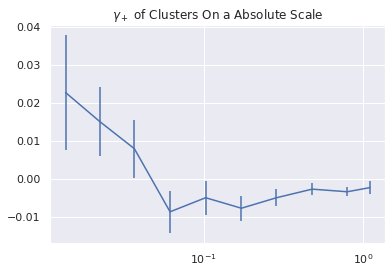

Aggregated xi:
[ -6.7595 -10.9201  -9.3311  19.2024  21.6186  70.7808  95.959  108.5718
 290.6701  99.1568]
------------------------------------------------------------------------------
Aggregated meanlogr:
[ -1276.0817  -2748.6142  -3869.9763  -6186.5017  -9939.3621 -16118.6833
 -24216.1643 -29676.4767 -19438.1133   4378.8656]
------------------------------------------------------------------------------
Aggregated npairs:
[  297.   723.  1172.  2220.  4374.  9180. 19389. 40428. 86207. 43510.]
------------------------------------------------------------------------------
Mean xi:
[-0.0228 -0.0151 -0.008   0.0086  0.0049  0.0077  0.0049  0.0027  0.0034
  0.0023]
------------------------------------------------------------------------------
Mean meanlogr:
[-4.2966 -3.8017 -3.302  -2.7867 -2.2724 -1.7558 -1.249  -0.7341 -0.2255
  0.1006]
------------------------------------------------------------------------------


In [30]:
plt_w_error(mean_abs[1],-mean_abs[0],sig_abs,r"$\gamma_+$ of Clusters On a Absolute Scale ")
print_data(sum_abs,mean_abs)

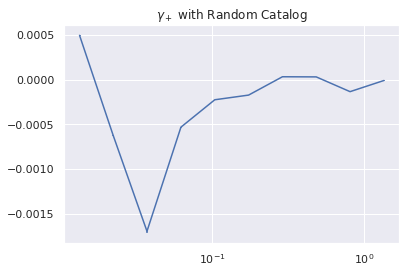

[ 4.9332e-04 -6.2438e-04 -1.6901e-03 -5.3002e-04 -2.2471e-04 -1.7261e-04
  3.1751e-05  3.0225e-05 -1.3427e-04 -1.0015e-05]
[-4.4173e-06  5.5909e-06  1.5134e-05  4.7459e-06  2.0121e-06  1.5456e-06
 -2.8431e-07 -2.7065e-07  1.2023e-06  8.9676e-08]


In [31]:
plt_w_error(r_meanlogr,-r_xi,r_sigma,r"$\gamma_+$ with Random Catalog")
print(-r_xi)
print(r_sigma)

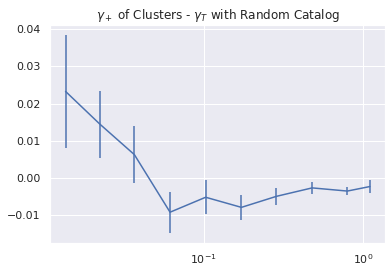

In [32]:
plt_w_error(mean_abs[1],-(mean_abs[0]+r_xi),np.hypot(r_sigma,sig_abs),r"$\gamma_+$ of Clusters - $\gamma_T$ with Random Catalog")

# Rel plots

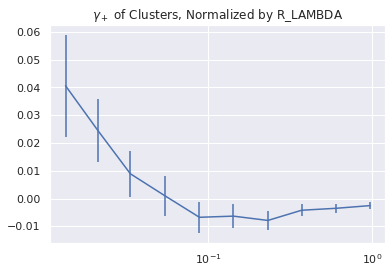

Aggregated xi:
[ -5.7653 -10.1888  -7.4655  -1.188   15.819   29.5849  72.6943  78.3042
 130.9329 190.3421]
------------------------------------------------------------------------------
Aggregated meanlogr:
[  -611.6153  -1599.5261  -2839.642   -3876.5251  -5696.1407  -9122.1534
 -13524.5291 -18462.0226 -18908.5075  -2282.7117]
------------------------------------------------------------------------------
Aggregated npairs:
[  142.   415.   836.  1335.  2348.  4680.  9238. 18665. 37414. 74993.]
------------------------------------------------------------------------------
Mean xi:
[-0.0406 -0.0246 -0.0089 -0.0009  0.0067  0.0063  0.0079  0.0042  0.0035
  0.0025]
------------------------------------------------------------------------------
Mean meanlogr:
[-4.3072 -3.8543 -3.3967 -2.9038 -2.426  -1.9492 -1.464  -0.9891 -0.5054
 -0.0304]
------------------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

In [33]:
plt_w_error(mean_rel[1],-mean_rel[0],sig_rel,r"$\gamma_+$ of Clusters, Normalized by R_LAMBDA")
print_data(sum_rel,mean_rel)